## US Contractor Market GTV (Gross Transaction Value) Prediction Model


# Table of contents of this notebook:
1. Package Downloads
2. Data download and preprocessing
3. Connecting to final data source
4. Exploring data
5. SARIMA, XGBoost, CatBoost, Prophet implementation
6. Error comparison
7. BigQuery connection setup

## Package Downloads

In [1]:
!pip install gspread pandas gspread_dataframe oauth2client
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install pytorch-forecasting
!pip install pytorch-lightning
!pip install catboost
!pip install pandas-gbq
!pip install google-cloud-bigquery
!pip install hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import requests
import pandas as pd
import zipfile
from io import BytesIO
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import get_as_dataframe
from google.colab import files
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
import warnings
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
from catboost import CatBoostRegressor
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import files
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data download and preprocessing

In [3]:
upload = files.upload()

Saving servicetitan-436706-73e8f924b15c.json to servicetitan-436706-73e8f924b15c.json


In [4]:
# Setup credentials
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("servicetitan-436706-73e8f924b15c.json", scope)
client = gspread.authorize(creds)

In [ ]:
# Folder to save extracted CSVs
output_folder = "bls_quarterly_data"
os.makedirs(output_folder, exist_ok=True)

# Loop over years
for year in range(2010, 2022):
    url = f"https://data.bls.gov/cew/data/files/{year}/csv/{year}_qtrly_by_industry.zip"
    print(f"Downloading: {url}")

    try:
        response = requests.get(url)
        response.raise_for_status()

        # Unzip the file content
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            z.extractall(output_folder)
            print(f"Extracted files for {year} to {output_folder}/")
    except Exception as e:
        print(f"❌ Failed to download or extract {year}: {e}")


Downloading: https://data.bls.gov/cew/data/files/2010/csv/2010_qtrly_by_industry.zip
Extracted files for 2010 to bls_quarterly_data/
Downloading: https://data.bls.gov/cew/data/files/2011/csv/2011_qtrly_by_industry.zip
Extracted files for 2011 to bls_quarterly_data/
Downloading: https://data.bls.gov/cew/data/files/2012/csv/2012_qtrly_by_industry.zip
Extracted files for 2012 to bls_quarterly_data/
Downloading: https://data.bls.gov/cew/data/files/2013/csv/2013_qtrly_by_industry.zip
Extracted files for 2013 to bls_quarterly_data/
Downloading: https://data.bls.gov/cew/data/files/2014/csv/2014_qtrly_by_industry.zip
Extracted files for 2014 to bls_quarterly_data/
Downloading: https://data.bls.gov/cew/data/files/2015/csv/2015_qtrly_by_industry.zip
Extracted files for 2015 to bls_quarterly_data/
Downloading: https://data.bls.gov/cew/data/files/2016/csv/2016_qtrly_by_industry.zip
Extracted files for 2016 to bls_quarterly_data/
Downloading: https://data.bls.gov/cew/data/files/2017/csv/2017_qtrly_

Creating combined dataframe.

In [ ]:
# Folder containing the downloaded CSV files
download_folder = "bls_quarterly_data"

# List of desired industry codes as strings
industry_codes = ['238222', '238161', '238162', '238211', '238212', '238221']

# Create an empty list to store DataFrames
all_dfs = []

# Use os.walk to traverse through all subfolders
for root, dirs, files in os.walk(download_folder):
    for filename in files:
        # Make filename comparison case-insensitive
        filename_lower = filename.lower()

        # Check for both .csv and .scv extensions
        if filename_lower.endswith((".csv", ".scv")):
            # Check if any of the industry codes are present in the filename (case-insensitive)
            if any(code in filename_lower for code in industry_codes):
                filepath = os.path.join(root, filename)  # Use root to get the full path

                try:
                    # Read the CSV into a DataFrame and append to the list
                    df = pd.read_csv(filepath)
                    all_dfs.append(df)
                except pd.errors.EmptyDataError:
                    print(f"Skipping empty file: {filename}")
                except pd.errors.ParserError:
                    print(f"Error parsing file: {filename}")
                except Exception as e:
                    print(f"An unexpected error occurred while reading {filename}: {e}")

# Concatenate all DataFrames into a single DataFrame
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("Combined DataFrame:")
    print(combined_df.head()) # Print the head of the combined DataFrame for verification
else:
    print("No matching CSV files found or processed successfully.")

Combined DataFrame:
  area_fips  own_code  industry_code  agglvl_code  size_code  year  qtr  \
0     01000         5         238161           58          0  2015    1   
1     01000         5         238161           58          0  2015    2   
2     01000         5         238161           58          0  2015    3   
3     01000         5         238161           58          0  2015    4   
4     01001         5         238161           78          0  2015    1   

  disclosure_code               area_title own_title  ...  \
0             NaN     Alabama -- Statewide   Private  ...   
1             NaN     Alabama -- Statewide   Private  ...   
2             NaN     Alabama -- Statewide   Private  ...   
3             NaN     Alabama -- Statewide   Private  ...   
4               N  Autauga County, Alabama   Private  ...   

  oty_qtrly_contributions_pct oty_avg_wkly_wage_chg oty_avg_wkly_wage_pct  \
0                       -25.2                    30                   5.6   
1       

Filtering out the necessary rows from the dataframe and downloading the resulting CSV file.

In [ ]:
combined_df = combined_df[combined_df['area_fips'] == 'US000']

# Create a CSV file with the combined data
combined_df.to_csv('combined_bls_data.csv', index=False)

# Download the file directly using files.download
files.download('combined_bls_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Connecting to final data source


Connected to the Excel sheet containing mapped data and linked it with macroeconomic estimations (e.g., GDP, BLS, IBIS Reports) for further forecasting.



In [5]:
# Check if the spreadsheet exists by iterating over the spreadsheets the user has access to
spreadsheet_found = False
for spreadsheet in client.openall():
    if spreadsheet.title == "Capstone Data Sheet - BLS + IBIS":
        sheet = spreadsheet
        spreadsheet_found = True
        break
# If it's not found, provide informative message
if not spreadsheet_found:
    raise ValueError("Spreadsheet 'Mapped Full Data Quarterly' not found. Please check the title and ensure the service account has access.")

quarterly_worksheet = sheet.worksheet("Mapped Full Data Quarterly")
quarterly_df = get_as_dataframe(quarterly_worksheet, evaluate_formulas=True)
quarterly_df.dropna(how='all', inplace=True)

print("Quarterly DataFrame:")
print(quarterly_df.head())

Quarterly DataFrame:
     Trade Business Focus          Trade+BF  industry_code    year  qtr  \
0  Roofing       Resi S&R  Roofing Resi S&R       238161.0  2010.0  1.0   
1  Roofing       Resi S&R  Roofing Resi S&R       238161.0  2010.0  2.0   
2  Roofing       Resi S&R  Roofing Resi S&R       238161.0  2010.0  3.0   
3  Roofing       Resi S&R  Roofing Resi S&R       238161.0  2010.0  4.0   
4  Roofing       Resi S&R  Roofing Resi S&R       238161.0  2011.0  1.0   

  yearqtr  qtrly_estabs_count  month1_emplvl  month2_emplvl  ...  \
0  2010Q1           13351.040      55958.272      55426.770  ...   
1  2010Q2           13517.928      64011.525      66425.052  ...   
2  2010Q3           13352.854      68272.611      68122.956  ...   
3  2010Q4           13280.294      67649.502      66409.633  ...   
4  2011Q1           13055.358      56155.091      56334.677  ...   

   oty_month1_emplvl_pct_chg  oty_month2_emplvl_pct_chg  \
0                        0.0                        0.0   
1

Convert 'yearqtr' column to datetime format and set it as the DataFrame index for time series operations.

In [6]:
quarterly_df['yearqtr'] = pd.to_datetime(quarterly_df['yearqtr'])
quarterly_df.set_index('yearqtr', inplace=True)

## Exploring data



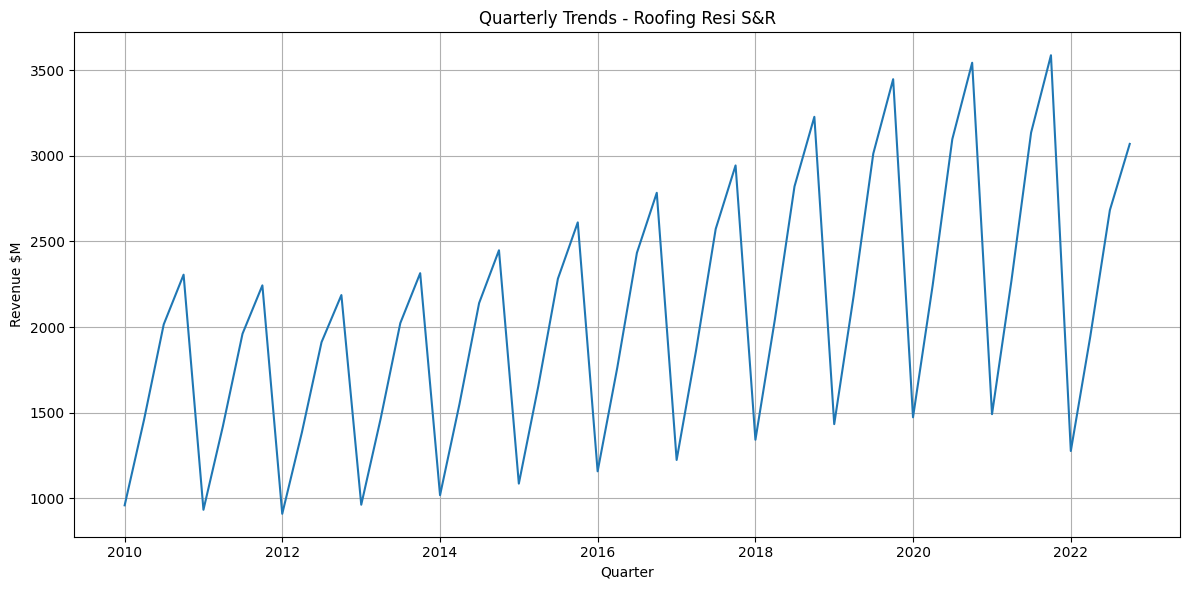

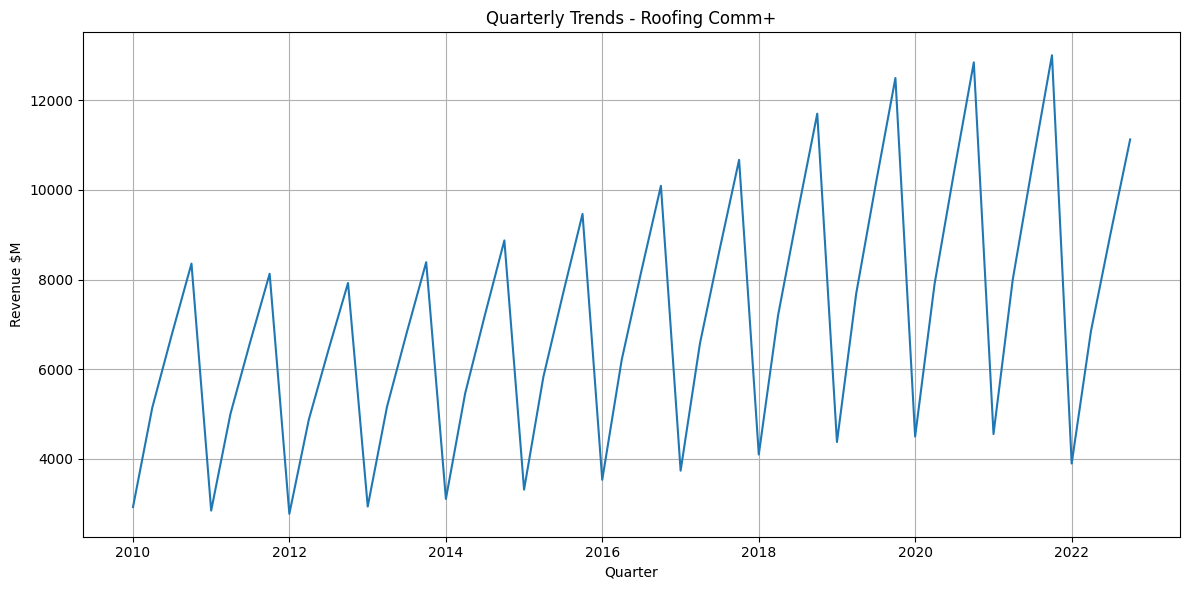

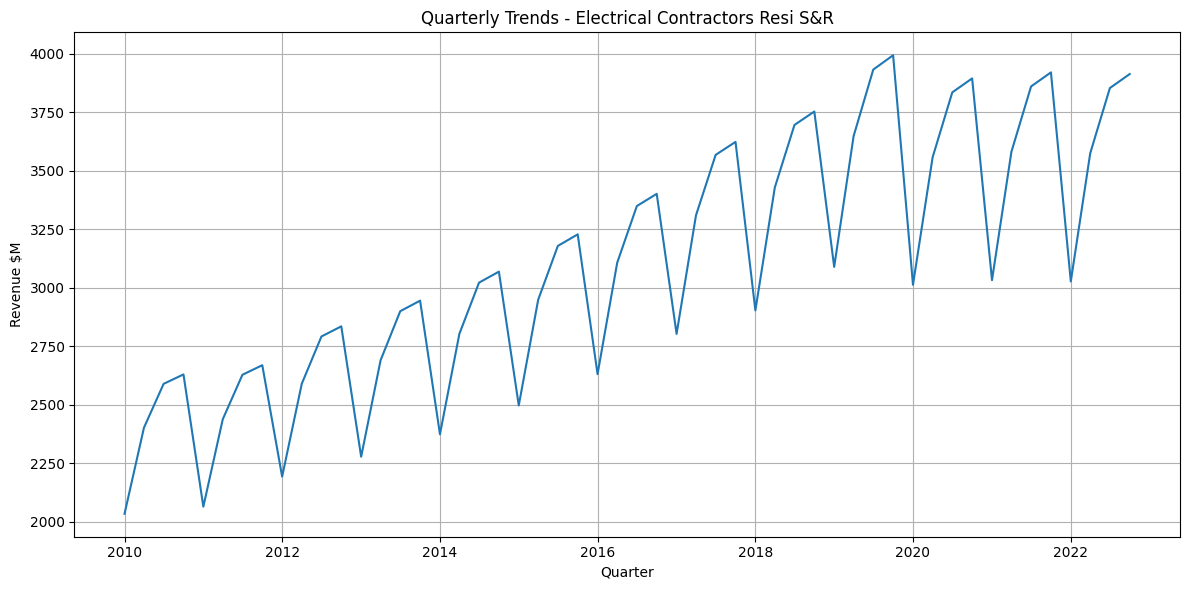

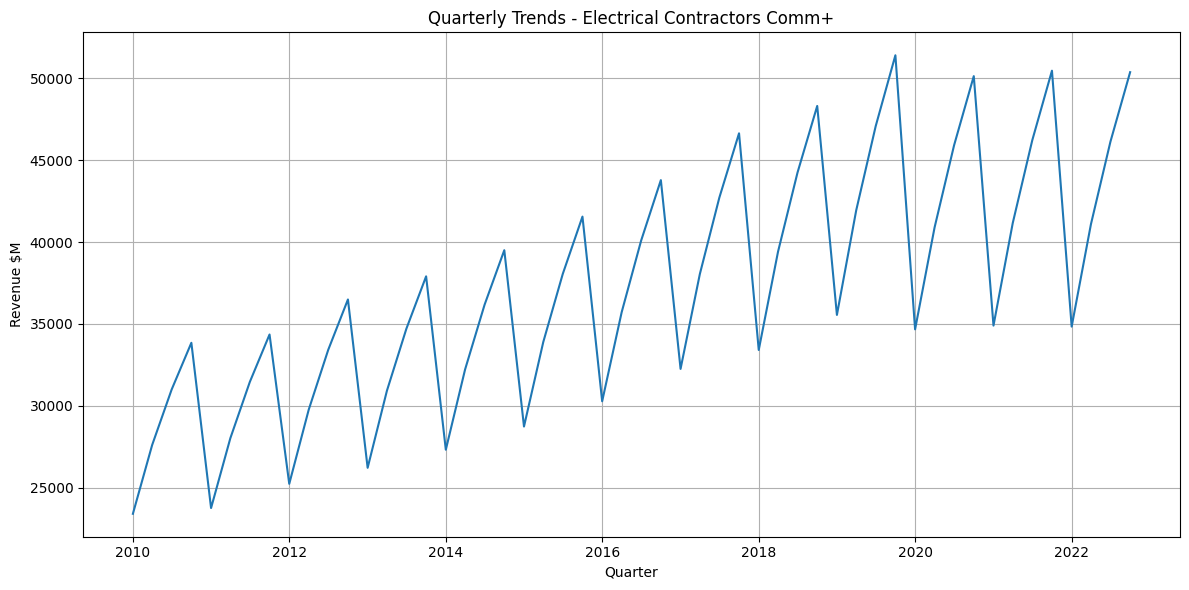

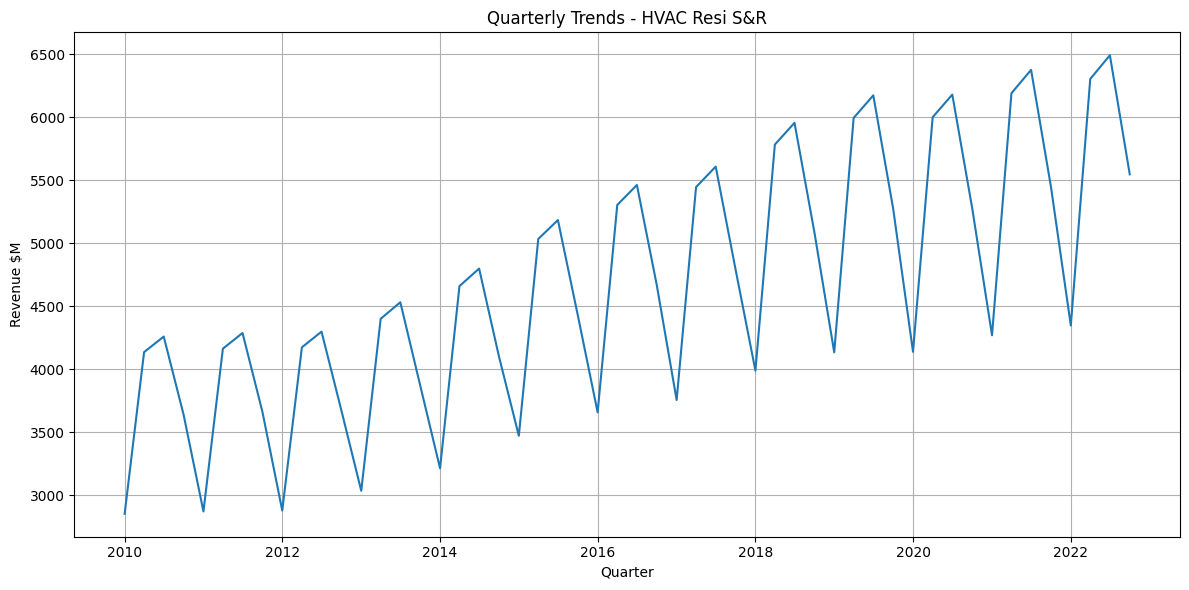

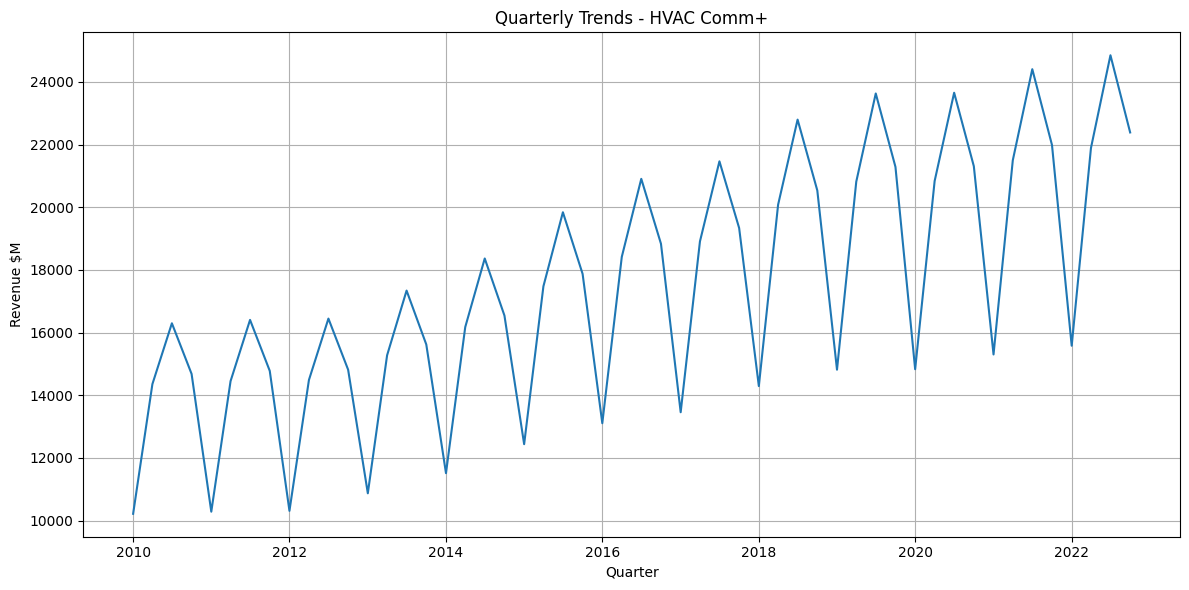

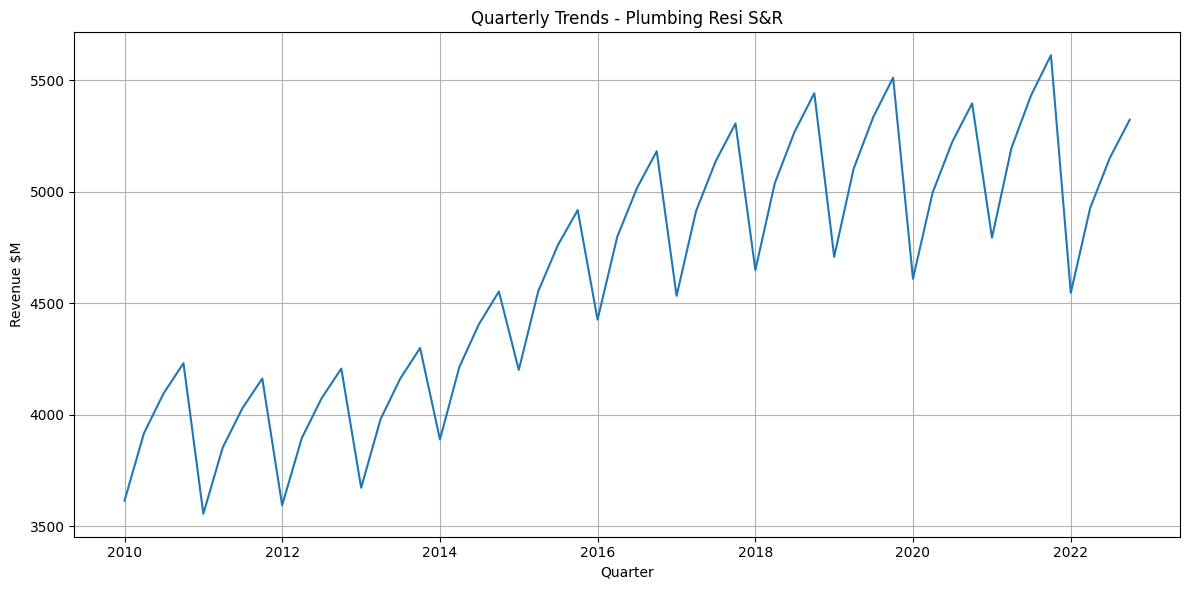

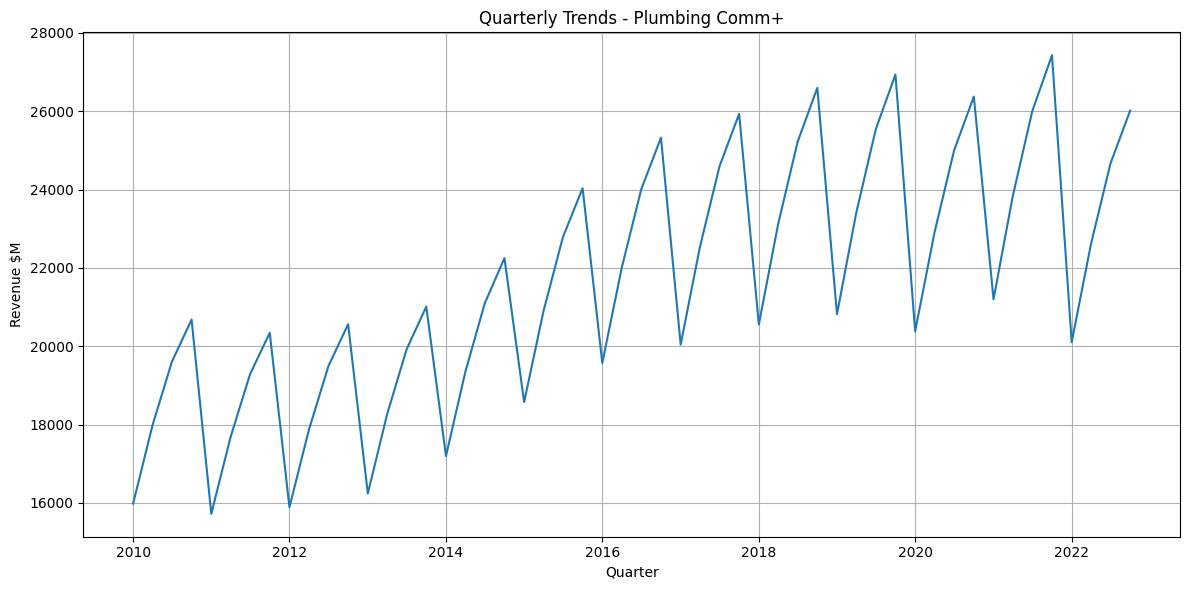

In [7]:
categories = quarterly_df['Trade+BF'].unique()

# Plot each category
for category in categories:
    subset = quarterly_df[quarterly_df['Trade+BF'] == category].sort_index() # Sort by index (yearqtr)

    plt.figure(figsize=(12, 6))
    plt.plot(subset.index, subset['Revenue'], label='Revenue') # Use .index to access yearqtr
    plt.title(f'Quarterly Trends - {category}')
    plt.xlabel('Quarter')
    plt.ylabel('Revenue $M')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Key observations:**

**Strong seasonality:**
All plots display a clear repeating annual pattern with peaks and troughs occurring at roughly the same quarters each year. This suggests seasonal cycles are a major driver of revenue in both residential and commercial business focuses.

**Upward trend:**
There's a consistent overall growth in revenue across years for both segments, with some minor fluctuations.

**Higher magnitude for commercial:**
Revenue for Comm+ is significantly higher than for Resi S&R, often by an order of magnitude, which is expected given the scale of commercial projects.

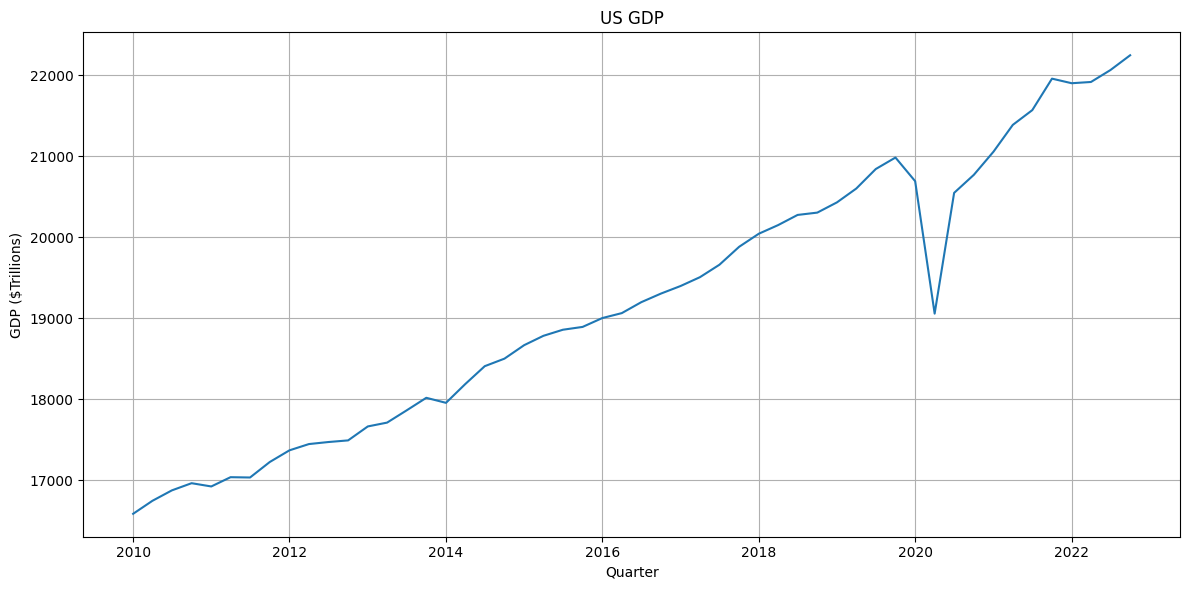

In [8]:
categories = quarterly_df['Trade+BF'].unique()
subset = quarterly_df[quarterly_df['Trade+BF'] == category].sort_index() # Sort by index (yearqtr)
plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset['GDP(Trillions $)'], label=' US GDP (Trillions $)') # Use .index to access yearqtr
plt.title(f'US GDP')
plt.xlabel('Quarter')
plt.ylabel('GDP ($Trillions)')
plt.grid(True)
plt.tight_layout()
plt.show()

Consistent Growth with COVID-19 Dip: U.S. GDP demonstrated steady quarterly growth from 2010 to 2019, followed by a sharp decline in 2020 due to the COVID-19 pandemic, and then a rapid recovery starting in late 2020.

Post-2021 Plateauing: After recovering to pre-pandemic levels, GDP growth appears to slow or plateau slightly around 2022–2023, potentially reflecting inflationary pressures, monetary tightening, or economic stabilization.

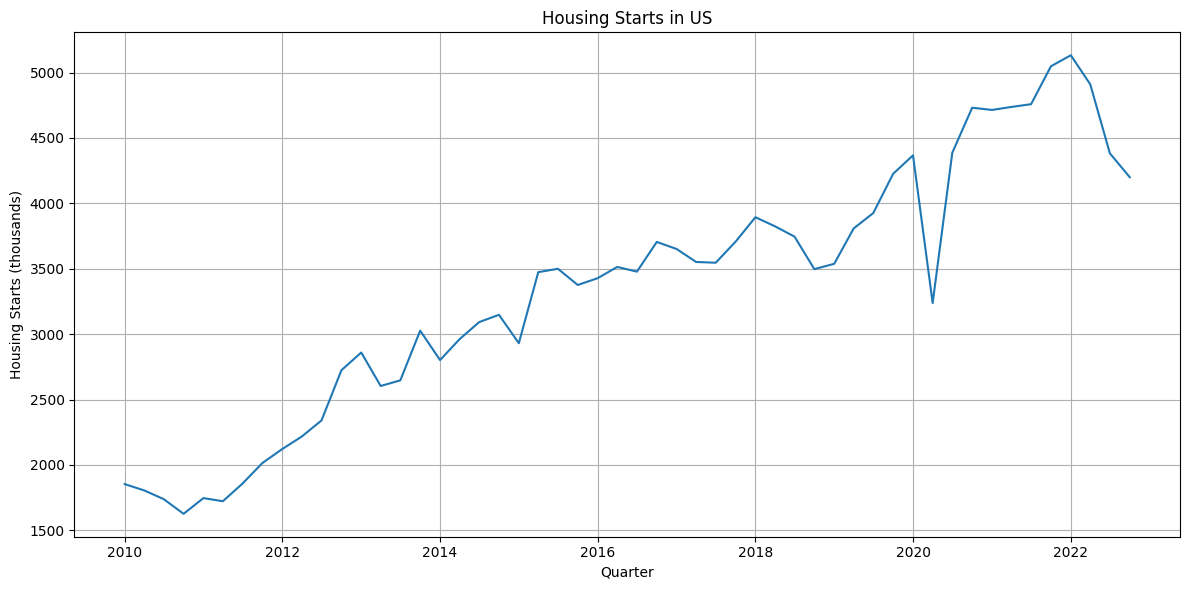

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset['Housing Starts'], label='Housing Starts in US') # Use .index to access yearqtr
plt.title(f'Housing Starts in US')
plt.xlabel('Quarter')
plt.ylabel('Housing Starts (thousands)')
plt.grid(True)
plt.tight_layout()
plt.show()

Steady Growth with Post-2020 Volatility: U.S. housing starts rose consistently from 2010 to 2019, reflecting a long-term recovery in residential construction, followed by sharp volatility due to COVID-19 disruptions and subsequent stimulus-driven rebound.

Recent Downward Trend: After peaking in 2022, housing starts have shown a noticeable decline, likely due to rising interest rates, inflation, and softening housing demand—factors that may negatively impact contractor market activity going forward.

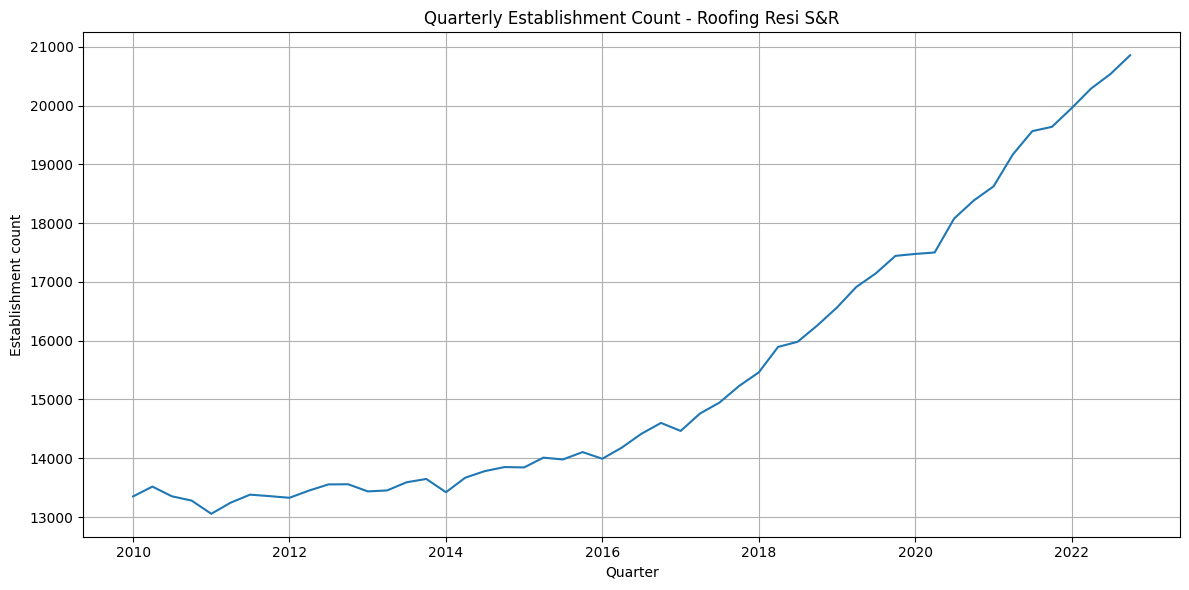

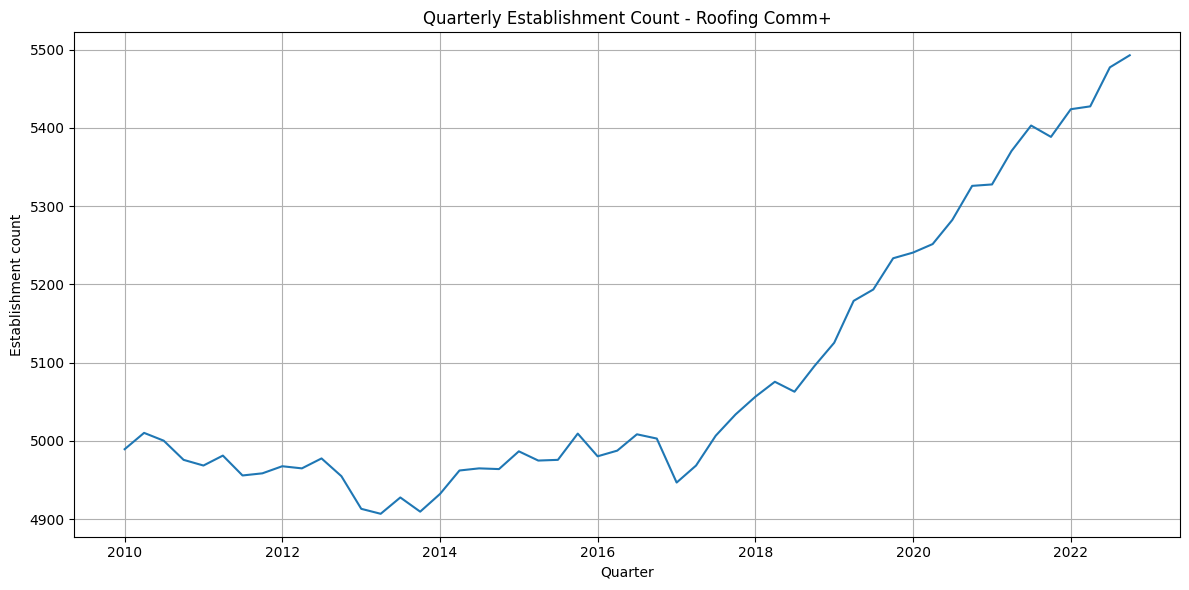

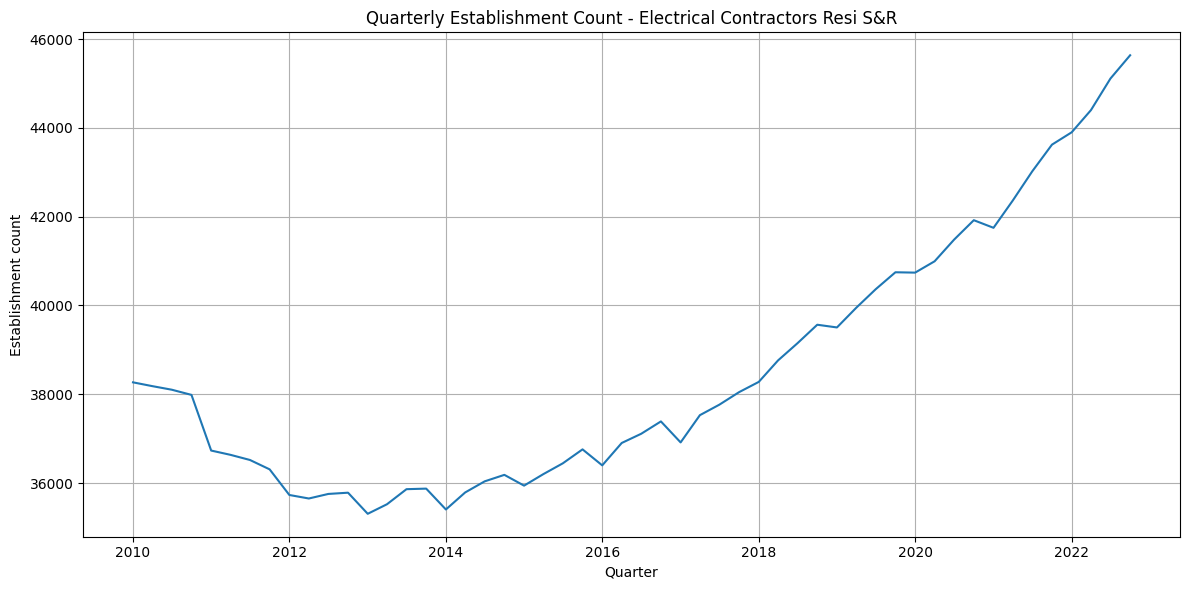

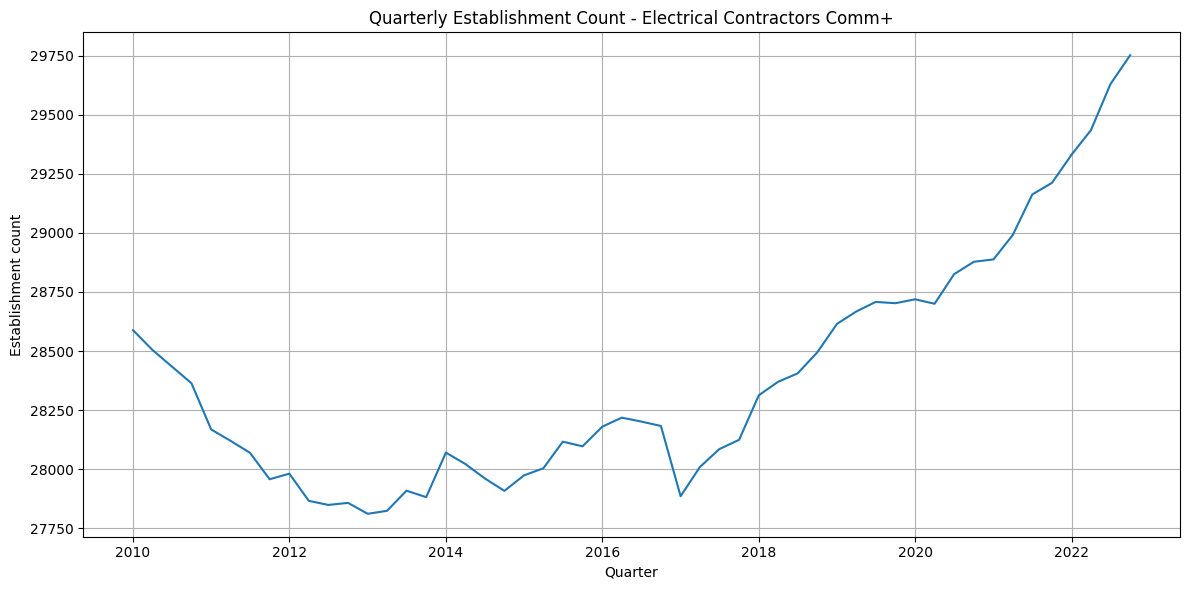

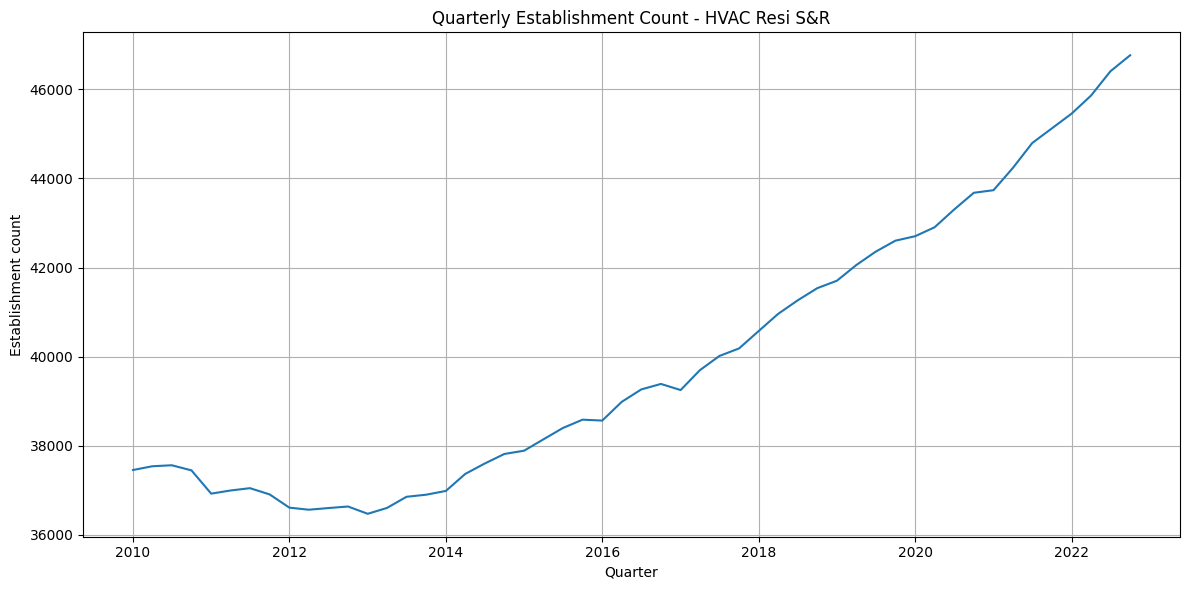

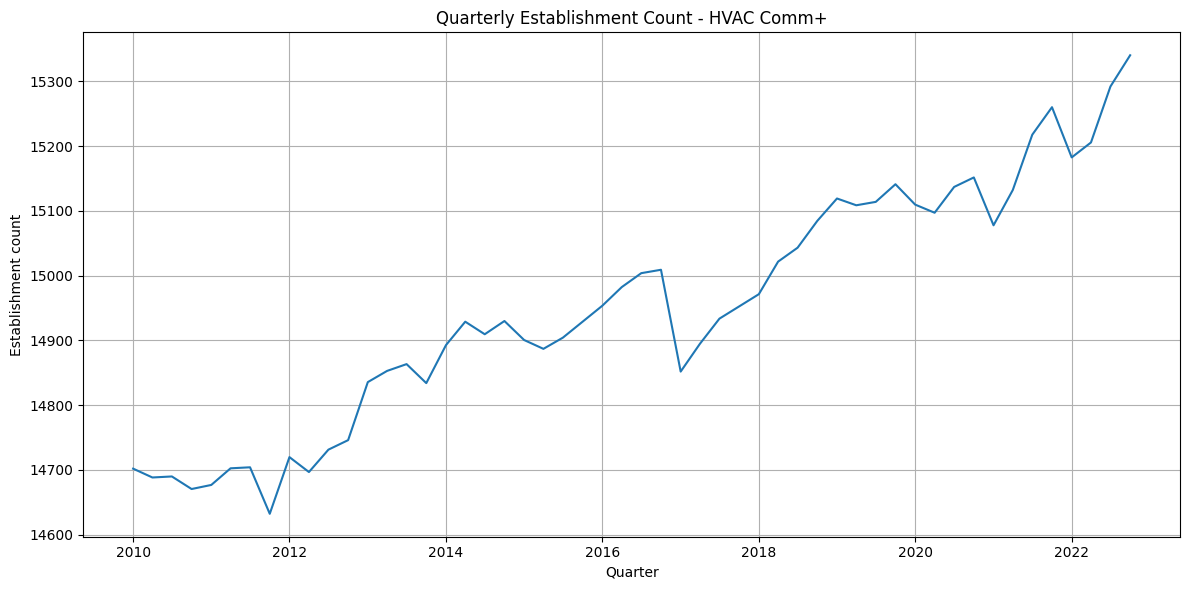

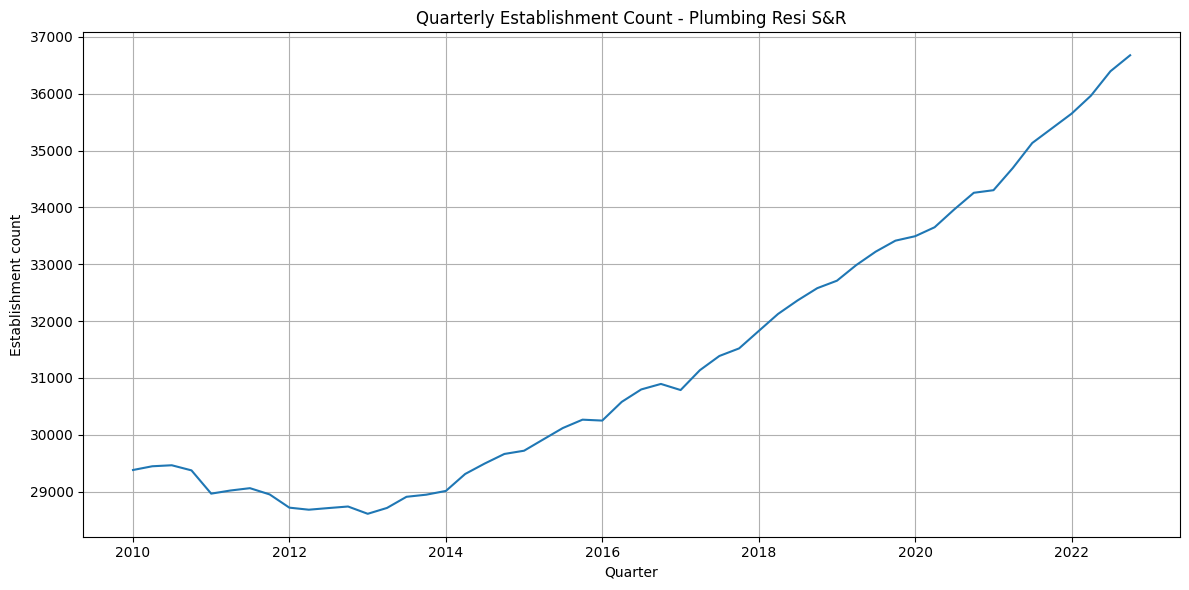

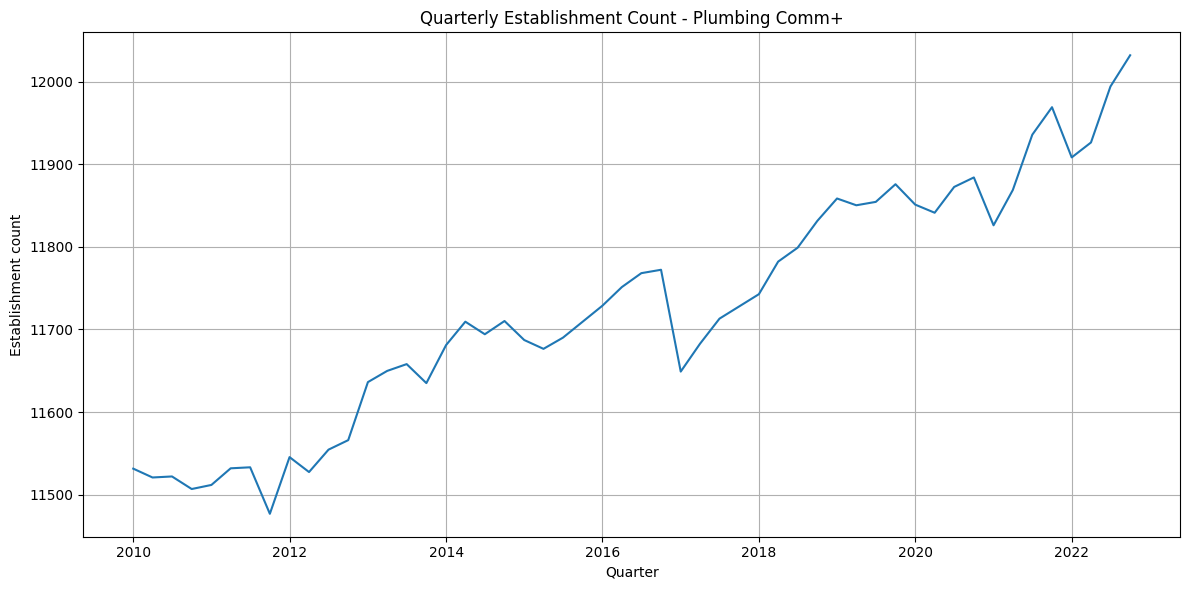

In [10]:
categories = quarterly_df['Trade+BF'].unique()

# Plot each category
for category in categories:
    subset = quarterly_df[quarterly_df['Trade+BF'] == category].sort_index()

    plt.figure(figsize=(12, 6))
    plt.plot(subset.index, subset['qtrly_estabs_count'], label='qtrly_estabs_count')
    plt.title(f'Quarterly Establishment Count - {category}')
    plt.xlabel('Quarter')
    plt.ylabel('Establishment count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We can see certain upward trend for all categories. Also, there is a steady growth Resdential Service & Replacement establishment count, while Commercials have fluctuations.

## SARIMA, XGBoost, CatBoost, Prophet implementation

Category: Roofing Resi S&R | Differencing order: 0


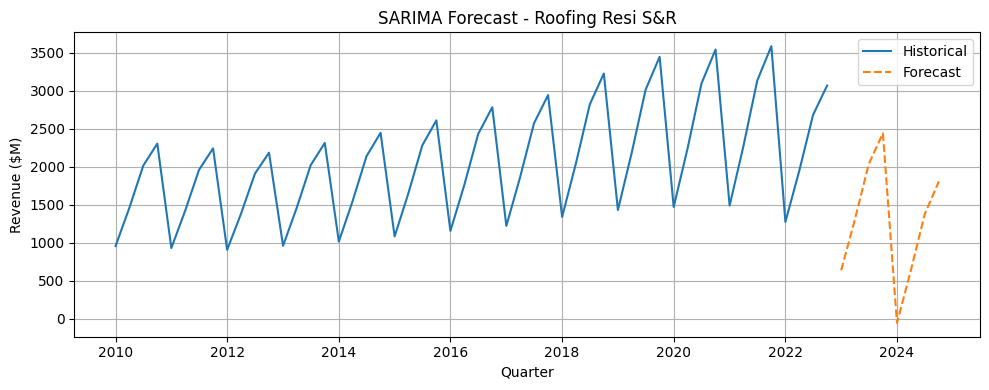

Category: Roofing Comm+ | Differencing order: 0


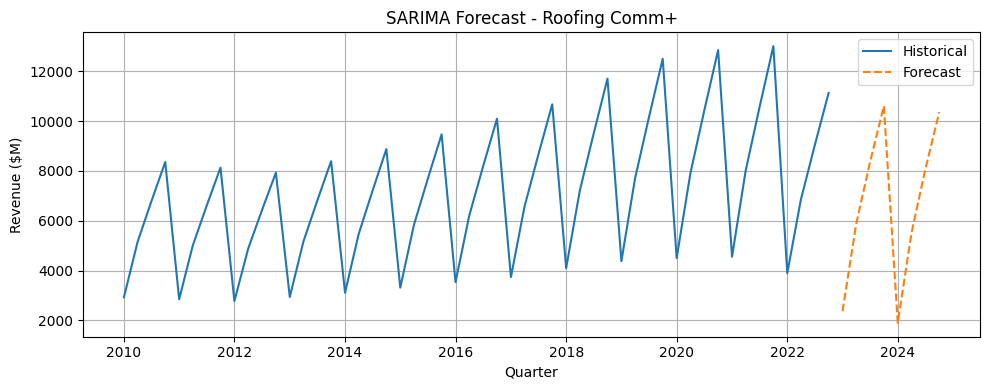

Category: Electrical Contractors Resi S&R | Differencing order: 2


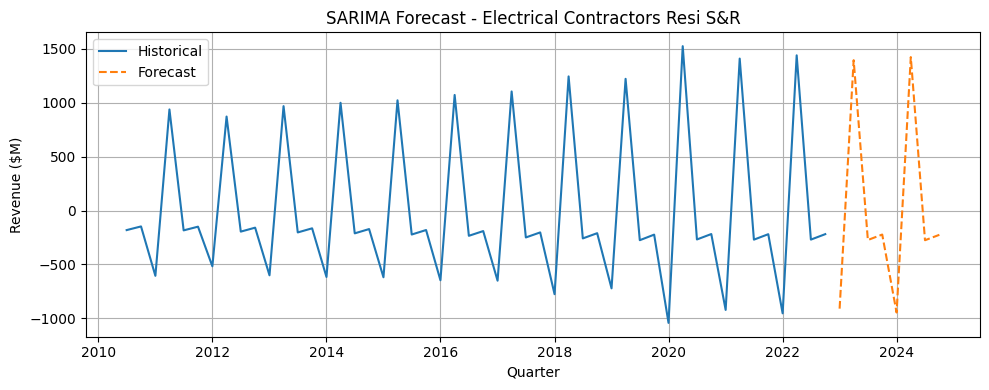

Category: Electrical Contractors Comm+ | Differencing order: 2


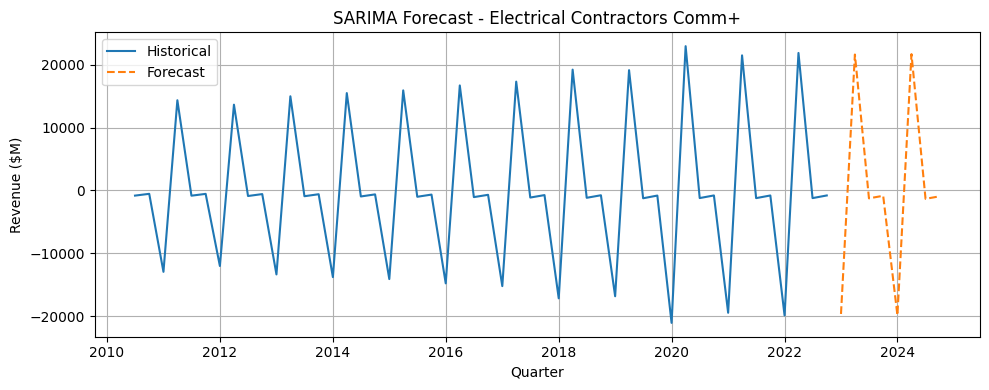

Category: HVAC Resi S&R | Differencing order: 2


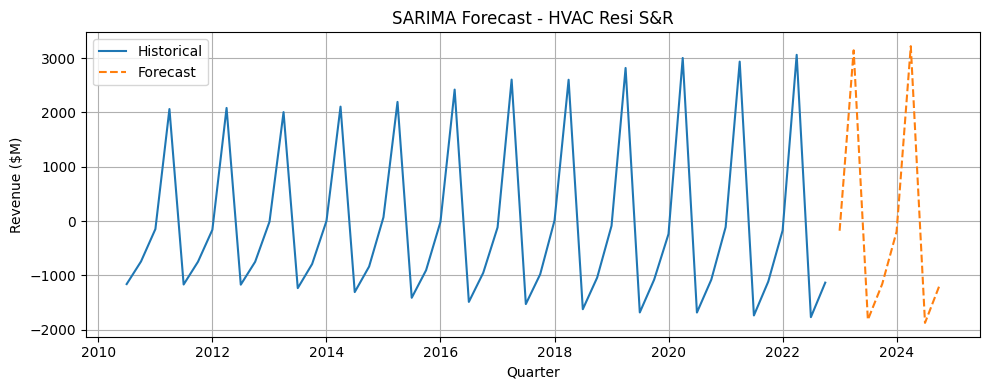

Category: HVAC Comm+ | Differencing order: 2


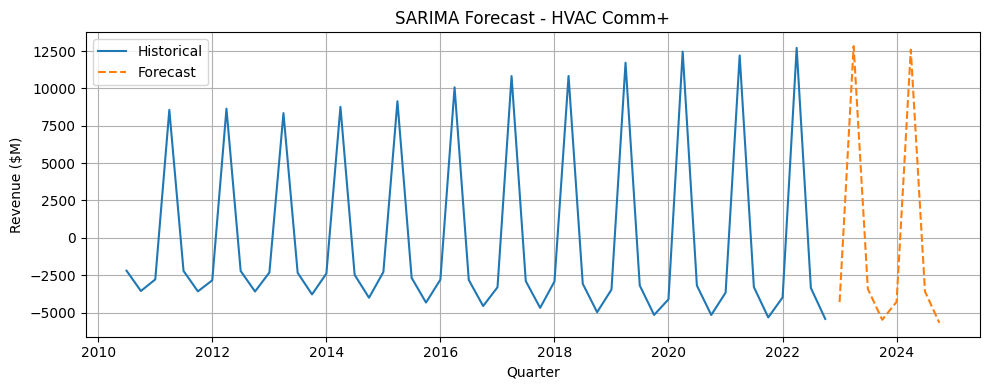

Category: Plumbing Resi S&R | Differencing order: 2


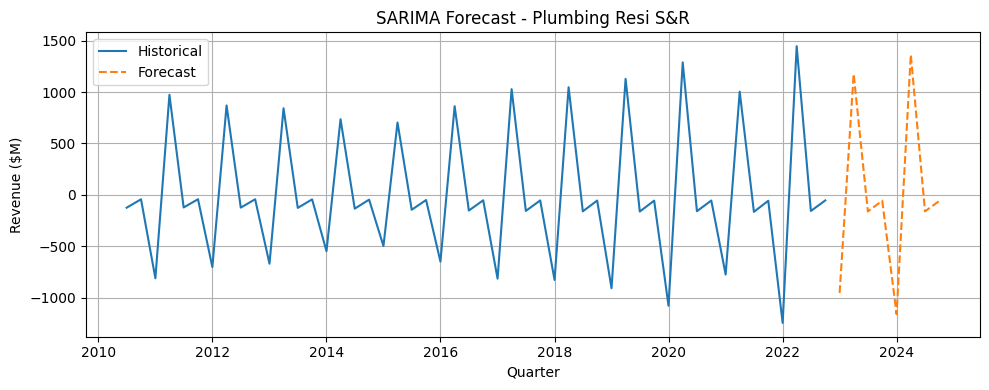

Category: Plumbing Comm+ | Differencing order: 2


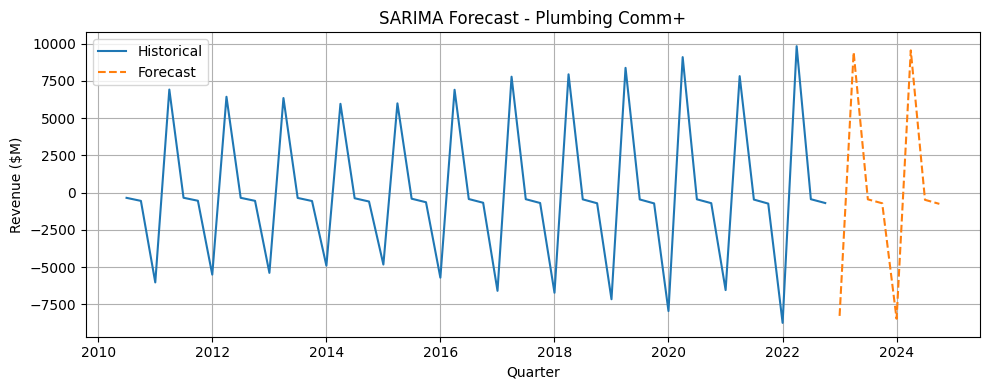


Error Metrics per Category:
Roofing Resi S&R | MAE: 161.38 | RMSE: 442.73 | MAPE: 10.38%
Roofing Comm+ | MAE: 630.95 | RMSE: 1569.08 | MAPE: 11.39%
Electrical Contractors Resi S&R | MAE: 162.87 | RMSE: 471.44 | MAPE: 49.96%
Electrical Contractors Comm+ | MAE: 2061.32 | RMSE: 5280.70 | MAPE: 118.56%
HVAC Resi S&R | MAE: 285.00 | RMSE: 813.87 | MAPE: 219.02%
HVAC Comm+ | MAE: 1051.20 | RMSE: 3052.82 | MAPE: 31.34%
Plumbing Resi S&R | MAE: 238.21 | RMSE: 541.57 | MAPE: 121.22%
Plumbing Comm+ | MAE: 1251.57 | RMSE: 2841.85 | MAPE: 111.95%


In [12]:
# Select first 8 categories
categories = quarterly_df['Trade+BF'].unique()[:8]
forecast_quarters = 8

# Initialize dictionaries to store error metrics and results
mae_dict = {}
rmse_dict = {}
mape_dict = {}
sarima_results = {}

# MAPE function
def mean_absolute_percentage_error(y_true, y_pred):

    """
    Calculates Mean Absolute Percentage Error (MAPE) between true and predicted values.

    Parameters
    ----------
    y_true : array-like
        Ground truth (actual) values.
    y_pred : array-like
        Predicted values from the model.

    Returns
    -------
    float
        MAPE score as a percentage (excluding zero targets).
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

# Stationarity check
def test_stationarity(ts):

    """
    Performs Augmented Dickey-Fuller (ADF) test to evaluate stationarity of a time series.

    Parameters
    ----------
    ts : pd.Series
        Time series data.

    Returns
    -------
    float
        p-value from the ADF test indicating stationarity (p < 0.05 suggests stationarity).
    """

    result = adfuller(ts.dropna())
    return result[1]

# Loop through each category
for category in categories:
    ts = quarterly_df[quarterly_df['Trade+BF'] == category]['Revenue'].asfreq('QS')

    if ts.empty or ts.shape[0] < 5:
        print(f"Skipping '{category}' due to insufficient data.")
        continue

    original_ts = ts.copy()

    p_val = test_stationarity(ts)
    d = 0
    while p_val > 0.05 and d < 2:
        ts = ts.diff().dropna()
        p_val = test_stationarity(ts)
        d += 1

    print(f"Category: {category} | Differencing order: {d}")

    try:
        # Fit SARIMA model
        model = SARIMAX(ts, order=(1, d, 1), seasonal_order=(1, 1, 1, 4))
        fitted = model.fit()

        # Get fitted values and align with actuals
        fitted_values = fitted.fittedvalues
        actual_values = ts[fitted_values.index]

        # Calculate error metrics
        mae = mean_absolute_error(actual_values, fitted_values)
        rmse = np.sqrt(mean_squared_error(actual_values, fitted_values))
        mape = mean_absolute_percentage_error(actual_values, fitted_values)

        # Store metrics
        mae_dict[category] = mae
        rmse_dict[category] = rmse
        mape_dict[category] = mape

        # Forecast
        forecast = fitted.get_forecast(steps=forecast_quarters)
        forecast_values = forecast.predicted_mean
        forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=3), periods=forecast_quarters, freq='QS')
        forecast_series = pd.Series(forecast_values, index=forecast_index)

        sarima_results[category] = {
            'dates': forecast_index,
            'values': forecast_values.values
        }

        # Plotting
        plt.figure(figsize=(10, 4))
        plt.plot(ts, label='Historical')
        plt.plot(forecast_series, label='Forecast', linestyle='--')
        plt.title(f"SARIMA Forecast - {category}")
        plt.xlabel("Quarter")
        plt.ylabel("Revenue ($M)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error for '{category}': {e}")

# Print results
print("\nError Metrics per Category:")
for cat in mae_dict:
    print(f"{cat} | MAE: {mae_dict[cat]:.2f} | RMSE: {rmse_dict[cat]:.2f} | MAPE: {mape_dict[cat]:.2f}%")


Performing time series forecasting for multiple categories (trades) using three models: XGBoost, CatBoost, and Prophet. For each category, preparing lag features, seasonal encodings, and rolling averages, then tuning hyperparameters using Hyperopt. It trains models, forecasts the next 8 quarters, and optionally runs backtesting to compute MAE, MAPE, and RMSE. Finally, it plots the actual historical revenue along with forecasts from each model for visual comparison.


Processing: Roofing Resi S&R
Features used for Roofing Resi S&R: ['year', 'qtr', 'qtrly_estabs_count', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'taxable_qtrly_wages', 'qtrly_contributions', 'avg_wkly_wage', 'lq_qtrly_estabs_count', 'lq_month1_emplvl', 'lq_month2_emplvl', 'lq_month3_emplvl', 'lq_total_qtrly_wages', 'lq_taxable_qtrly_wages', 'lq_qtrly_contributions', 'lq_avg_wkly_wage', 'oty_qtrly_estabs_count_chg', 'oty_qtrly_estabs_count_pct_chg', 'oty_month1_emplvl_chg', 'oty_month1_emplvl_pct', 'oty_month2_emplvl_chg', 'oty_month2_emplvl_pct', 'oty_month3_emplvl_chg', 'oty_month3_emplvl_pct', 'oty_total_qtrly_wages_chg', 'oty_total_qtrly_wages_pct', 'oty_taxable_qtrly_wages_chg', 'oty_taxable_qtrly_wages_chg.1', 'oty_qtrly_contributions_chg', 'oty_qtrly_contributions_pct', 'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct', 'oty_month1_emplvl_pct_chg', 'oty_month2_emplvl_pct_chg', 'oty_month3_emplvl_pct_chg', 'oty_total_qtrly_wages_pct_chg', 'oty_taxable

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/4nerx_ik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/6g_ssols.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26567', 'data', 'file=/tmp/tmpkatl30rk/4nerx_ik.json', 'init=/tmp/tmpkatl30rk/6g_ssols.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modelqxyeu3fd/prophet_model-20250509175639.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 80/80 [02:01<00:00,  1.52s/trial, best loss: 288.8229612387587]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/hxb84p7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/lqpf4kq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82547', 'data', 'file=/tmp/tmpkatl30rk/hxb84p7n.json', 'init=/tmp/tmpkatl30rk/lqpf4kq0.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modeln2slt508/prophet_model-20250509175920.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Backtest metrics for Roofing Resi S&R:
  XGBoost -> MAE: 554.26, MAPE: 2293.52%, RMSE: 654.79
  CatBoost -> MAE: 747.99, MAPE: 3091.22%, RMSE: 873.25
  Prophet -> MAE: 391.20, MAPE: 1717.89%, RMSE: 495.04


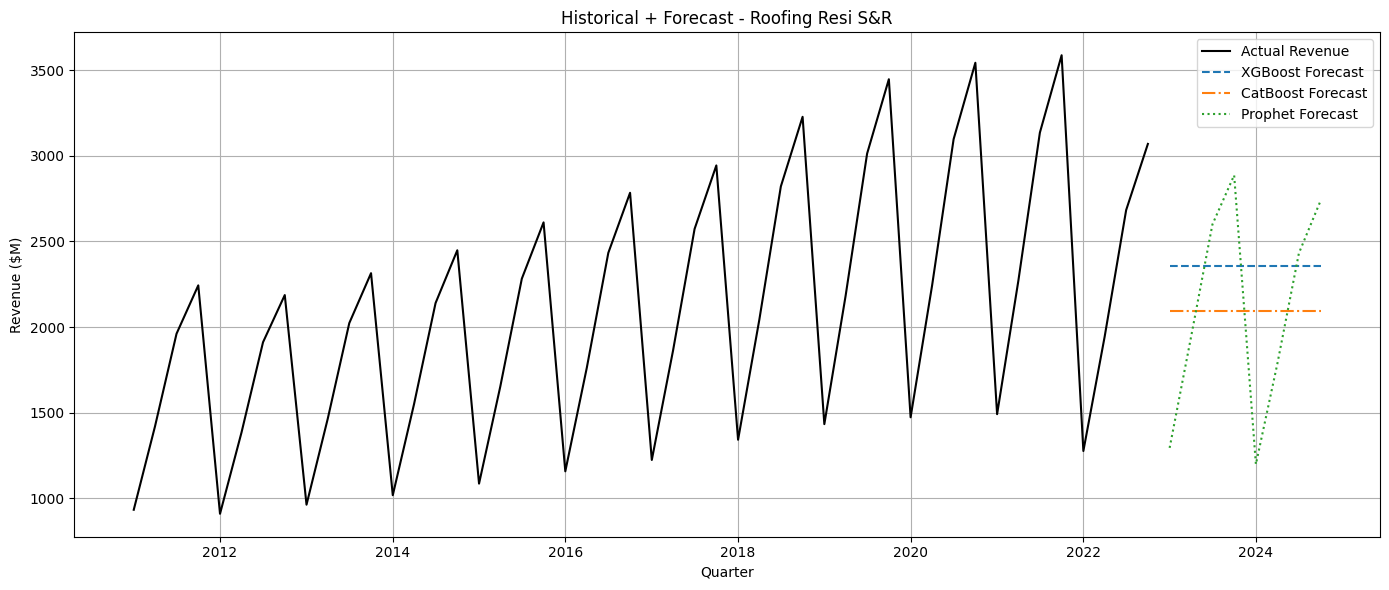

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/qt02yie2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/dpcmmq67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85865', 'data', 'file=/tmp/tmpkatl30rk/qt02yie2.json', 'init=/tmp/tmpkatl30rk/dpcmmq67.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modelqno8zw92/prophet_model-20250509175922.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:59:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Processing: Roofing Comm+
Features used for Roofing Comm+: ['year', 'qtr', 'qtrly_estabs_count', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'taxable_qtrly_wages', 'qtrly_contributions', 'avg_wkly_wage', 'lq_qtrly_estabs_count', 'lq_month1_emplvl', 'lq_month2_emplvl', 'lq_month3_emplvl', 'lq_total_qtrly_wages', 'lq_taxable_qtrly_wages', 'lq_qtrly_contributions', 'lq_avg_wkly_wage', 'oty_qtrly_estabs_count_chg', 'oty_qtrly_estabs_count_pct_chg', 'oty_month1_emplvl_chg', 'oty_month1_emplvl_pct', 'oty_month2_emplvl_chg', 'oty_month2_emplvl_pct', 'oty_month3_emplvl_chg', 'oty_month3_emplvl_pct', 'oty_total_qtrly_wages_chg', 'oty_total_qtrly_wages_pct', 'oty_taxable_qtrly_wages_chg', 'oty_taxable_qtrly_wages_chg.1', 'oty_qtrly_contributions_chg', 'oty_qtrly_contributions_pct', 'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct', 'oty_month1_emplvl_pct_chg', 'oty_month2_emplvl_pct_chg', 'oty_month3_emplvl_pct_chg', 'oty_total_qtrly_wages_pct_chg', 'oty_taxable_qtrly

17:59:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 80/80 [02:26<00:00,  1.84s/trial, best loss: 1165.045265600357]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/z09zwbgf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/2p8_itlh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49853', 'data', 'file=/tmp/tmpkatl30rk/z09zwbgf.json', 'init=/tmp/tmpkatl30rk/2p8_itlh.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modeltpmpxvtw/prophet_model-20250509180236.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:02:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Backtest metrics for Roofing Comm+:
  XGBoost -> MAE: 2485.00, MAPE: 3202.01%, RMSE: 2920.63
  CatBoost -> MAE: 2802.95, MAPE: 3587.15%, RMSE: 3292.19
  Prophet -> MAE: 1352.63, MAPE: 1726.97%, RMSE: 1729.06


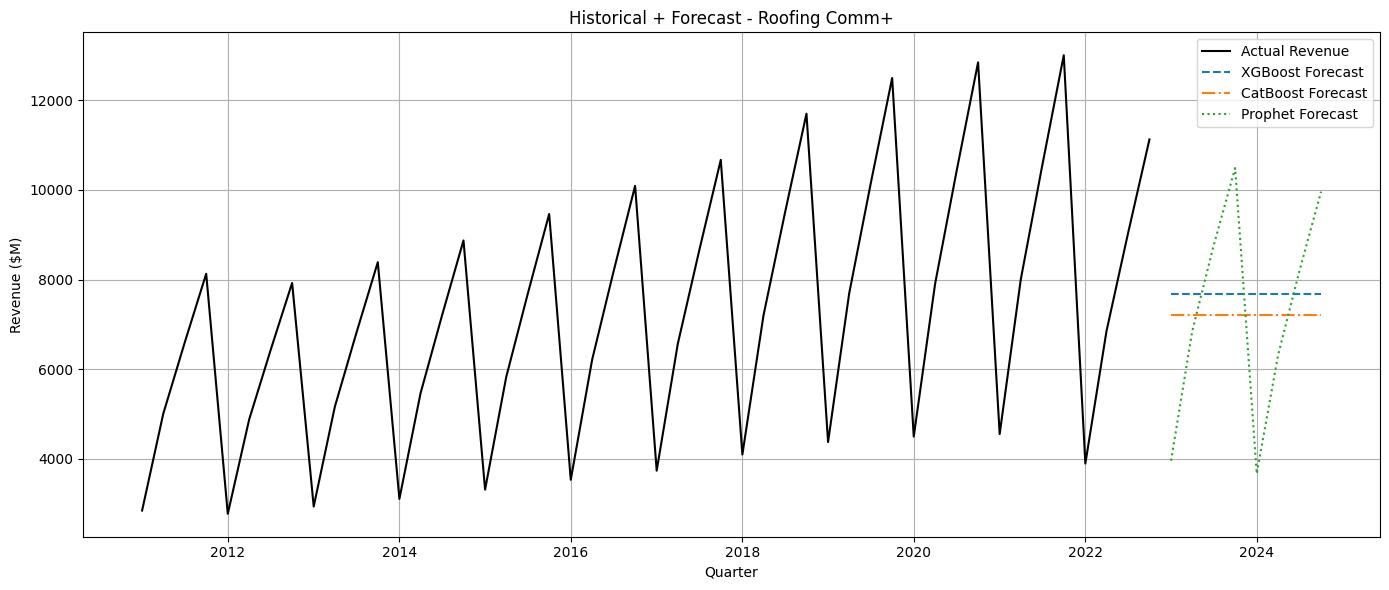

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/q_1nkovm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/z_engqqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80215', 'data', 'file=/tmp/tmpkatl30rk/q_1nkovm.json', 'init=/tmp/tmpkatl30rk/z_engqqn.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_model0yjozzxf/prophet_model-20250509180238.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:02:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Processing: Electrical Contractors Resi S&R
Features used for Electrical Contractors Resi S&R: ['year', 'qtr', 'qtrly_estabs_count', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'taxable_qtrly_wages', 'qtrly_contributions', 'avg_wkly_wage', 'lq_qtrly_estabs_count', 'lq_month1_emplvl', 'lq_month2_emplvl', 'lq_month3_emplvl', 'lq_total_qtrly_wages', 'lq_taxable_qtrly_wages', 'lq_qtrly_contributions', 'lq_avg_wkly_wage', 'oty_qtrly_estabs_count_chg', 'oty_qtrly_estabs_count_pct_chg', 'oty_month1_emplvl_chg', 'oty_month1_emplvl_pct', 'oty_month2_emplvl_chg', 'oty_month2_emplvl_pct', 'oty_month3_emplvl_chg', 'oty_month3_emplvl_pct', 'oty_total_qtrly_wages_chg', 'oty_total_qtrly_wages_pct', 'oty_taxable_qtrly_wages_chg', 'oty_taxable_qtrly_wages_chg.1', 'oty_qtrly_contributions_chg', 'oty_qtrly_contributions_pct', 'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct', 'oty_month1_emplvl_pct_chg', 'oty_month2_emplvl_pct_chg', 'oty_month3_emplvl_pct_chg', 'oty_total_qtrl

18:02:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 80/80 [02:30<00:00,  1.88s/trial, best loss: 260.0441106741918]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/tddu47vz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/i3ienfgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2873', 'data', 'file=/tmp/tmpkatl30rk/tddu47vz.json', 'init=/tmp/tmpkatl30rk/i3ienfgo.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modell8iuibhw/prophet_model-20250509180540.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Backtest metrics for Electrical Contractors Resi S&R:
  XGBoost -> MAE: 3594.83, MAPE: 9998.59%, RMSE: 3611.88
  CatBoost -> MAE: 546.80, MAPE: 1441.72%, RMSE: 633.98
  Prophet -> MAE: 198.10, MAPE: 555.87%, RMSE: 210.18


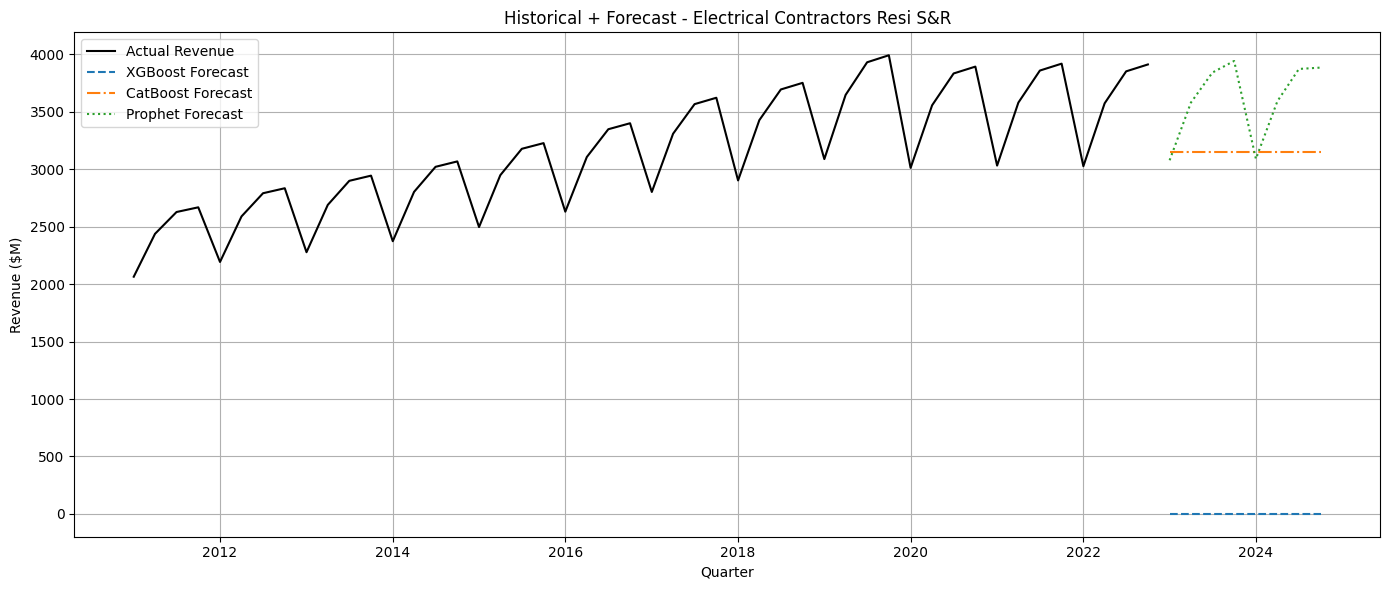

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/1md1rxp2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/w2wne0qw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91729', 'data', 'file=/tmp/tmpkatl30rk/1md1rxp2.json', 'init=/tmp/tmpkatl30rk/w2wne0qw.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_model_de4764z/prophet_model-20250509180541.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Processing: Electrical Contractors Comm+
Features used for Electrical Contractors Comm+: ['year', 'qtr', 'qtrly_estabs_count', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'taxable_qtrly_wages', 'qtrly_contributions', 'avg_wkly_wage', 'lq_qtrly_estabs_count', 'lq_month1_emplvl', 'lq_month2_emplvl', 'lq_month3_emplvl', 'lq_total_qtrly_wages', 'lq_taxable_qtrly_wages', 'lq_qtrly_contributions', 'lq_avg_wkly_wage', 'oty_qtrly_estabs_count_chg', 'oty_qtrly_estabs_count_pct_chg', 'oty_month1_emplvl_chg', 'oty_month1_emplvl_pct', 'oty_month2_emplvl_chg', 'oty_month2_emplvl_pct', 'oty_month3_emplvl_chg', 'oty_month3_emplvl_pct', 'oty_total_qtrly_wages_chg', 'oty_total_qtrly_wages_pct', 'oty_taxable_qtrly_wages_chg', 'oty_taxable_qtrly_wages_chg.1', 'oty_qtrly_contributions_chg', 'oty_qtrly_contributions_pct', 'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct', 'oty_month1_emplvl_pct_chg', 'oty_month2_emplvl_pct_chg', 'oty_month3_emplvl_pct_chg', 'oty_total_qtrly_wage

18:05:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 80/80 [02:30<00:00,  1.88s/trial, best loss: 3300.0367380323364]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/g8txnlda.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/d5ywf11c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25941', 'data', 'file=/tmp/tmpkatl30rk/g8txnlda.json', 'init=/tmp/tmpkatl30rk/d5ywf11c.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modelehj7drrp/prophet_model-20250509180849.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Backtest metrics for Electrical Contractors Comm+:
  XGBoost -> MAE: 6828.27, MAPE: 1479.64%, RMSE: 8037.67
  CatBoost -> MAE: 7306.51, MAPE: 1583.19%, RMSE: 8591.38
  Prophet -> MAE: 2553.31, MAPE: 598.30%, RMSE: 2712.35


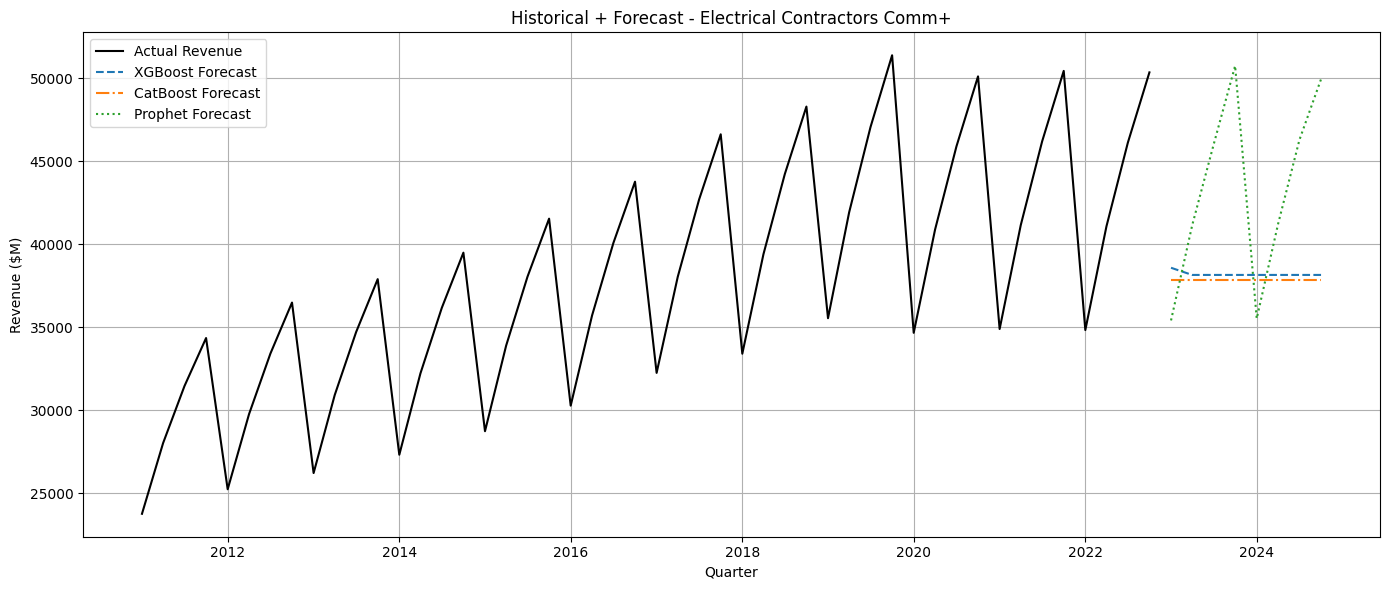

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/b7w239nj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/rap4elff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11125', 'data', 'file=/tmp/tmpkatl30rk/b7w239nj.json', 'init=/tmp/tmpkatl30rk/rap4elff.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modeljpfoct_h/prophet_model-20250509180850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Processing: HVAC Resi S&R
Features used for HVAC Resi S&R: ['year', 'qtr', 'qtrly_estabs_count', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'taxable_qtrly_wages', 'qtrly_contributions', 'avg_wkly_wage', 'lq_qtrly_estabs_count', 'lq_month1_emplvl', 'lq_month2_emplvl', 'lq_month3_emplvl', 'lq_total_qtrly_wages', 'lq_taxable_qtrly_wages', 'lq_qtrly_contributions', 'lq_avg_wkly_wage', 'oty_qtrly_estabs_count_chg', 'oty_qtrly_estabs_count_pct_chg', 'oty_month1_emplvl_chg', 'oty_month1_emplvl_pct', 'oty_month2_emplvl_chg', 'oty_month2_emplvl_pct', 'oty_month3_emplvl_chg', 'oty_month3_emplvl_pct', 'oty_total_qtrly_wages_chg', 'oty_total_qtrly_wages_pct', 'oty_taxable_qtrly_wages_chg', 'oty_taxable_qtrly_wages_chg.1', 'oty_qtrly_contributions_chg', 'oty_qtrly_contributions_pct', 'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct', 'oty_month1_emplvl_pct_chg', 'oty_month2_emplvl_pct_chg', 'oty_month3_emplvl_pct_chg', 'oty_total_qtrly_wages_pct_chg', 'oty_taxable_qtrly

18:08:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 80/80 [02:44<00:00,  2.06s/trial, best loss: 472.5274948621075]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/jli2l9hy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/ncvsnpd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73979', 'data', 'file=/tmp/tmpkatl30rk/jli2l9hy.json', 'init=/tmp/tmpkatl30rk/ncvsnpd7.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modeldw2r6b54/prophet_model-20250509181214.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Backtest metrics for HVAC Resi S&R:
  XGBoost -> MAE: 1076.90, MAPE: 1792.87%, RMSE: 1226.41
  CatBoost -> MAE: 1175.40, MAPE: 1959.46%, RMSE: 1332.68
  Prophet -> MAE: 223.71, MAPE: 382.14%, RMSE: 247.48


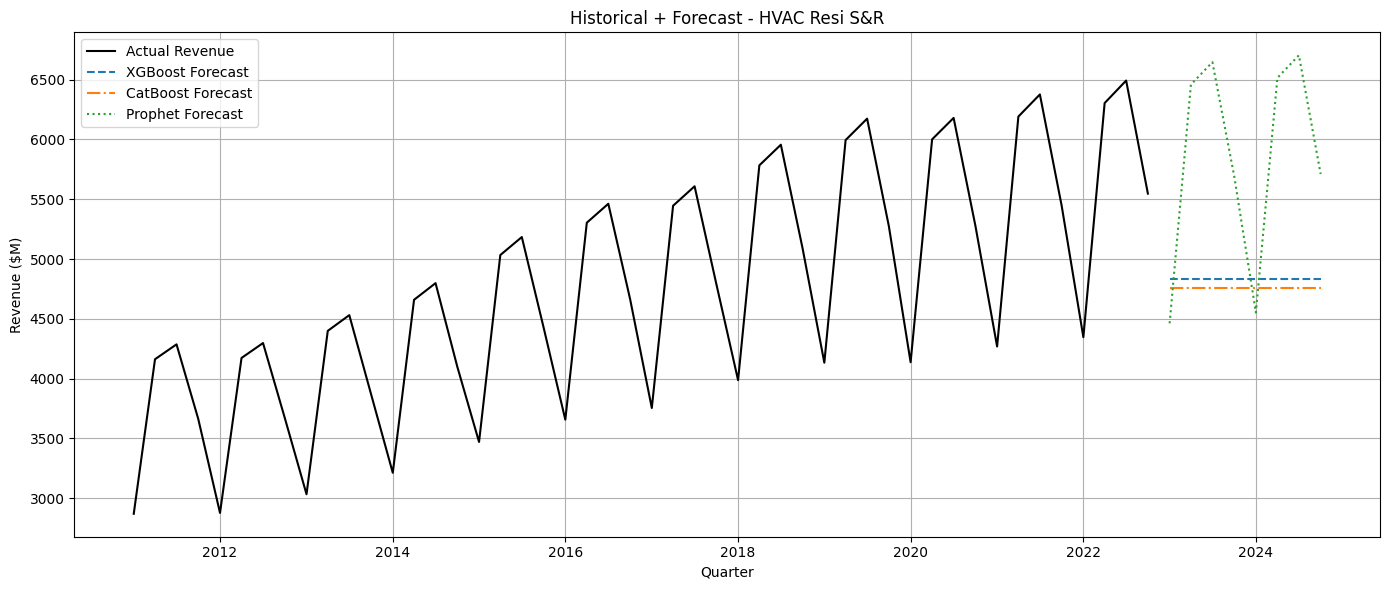

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/69y41ggn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/y0vxut46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40090', 'data', 'file=/tmp/tmpkatl30rk/69y41ggn.json', 'init=/tmp/tmpkatl30rk/y0vxut46.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_model76_e70xu/prophet_model-20250509181215.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Processing: HVAC Comm+
Features used for HVAC Comm+: ['year', 'qtr', 'qtrly_estabs_count', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'taxable_qtrly_wages', 'qtrly_contributions', 'avg_wkly_wage', 'lq_qtrly_estabs_count', 'lq_month1_emplvl', 'lq_month2_emplvl', 'lq_month3_emplvl', 'lq_total_qtrly_wages', 'lq_taxable_qtrly_wages', 'lq_qtrly_contributions', 'lq_avg_wkly_wage', 'oty_qtrly_estabs_count_chg', 'oty_qtrly_estabs_count_pct_chg', 'oty_month1_emplvl_chg', 'oty_month1_emplvl_pct', 'oty_month2_emplvl_chg', 'oty_month2_emplvl_pct', 'oty_month3_emplvl_chg', 'oty_month3_emplvl_pct', 'oty_total_qtrly_wages_chg', 'oty_total_qtrly_wages_pct', 'oty_taxable_qtrly_wages_chg', 'oty_taxable_qtrly_wages_chg.1', 'oty_qtrly_contributions_chg', 'oty_qtrly_contributions_pct', 'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct', 'oty_month1_emplvl_pct_chg', 'oty_month2_emplvl_pct_chg', 'oty_month3_emplvl_pct_chg', 'oty_total_qtrly_wages_pct_chg', 'oty_taxable_qtrly_wages

18:12:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 80/80 [02:10<00:00,  1.63s/trial, best loss: 1969.7193662674656]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/mqrgg0i4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/q8ux5vzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46745', 'data', 'file=/tmp/tmpkatl30rk/mqrgg0i4.json', 'init=/tmp/tmpkatl30rk/q8ux5vzt.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modeli9t30i_c/prophet_model-20250509181501.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:15:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Backtest metrics for HVAC Comm+:
  XGBoost -> MAE: 20986.06, MAPE: 9999.75%, RMSE: 21258.66
  CatBoost -> MAE: 4707.34, MAPE: 2131.82%, RMSE: 5147.37
  Prophet -> MAE: 850.13, MAPE: 382.65%, RMSE: 950.77


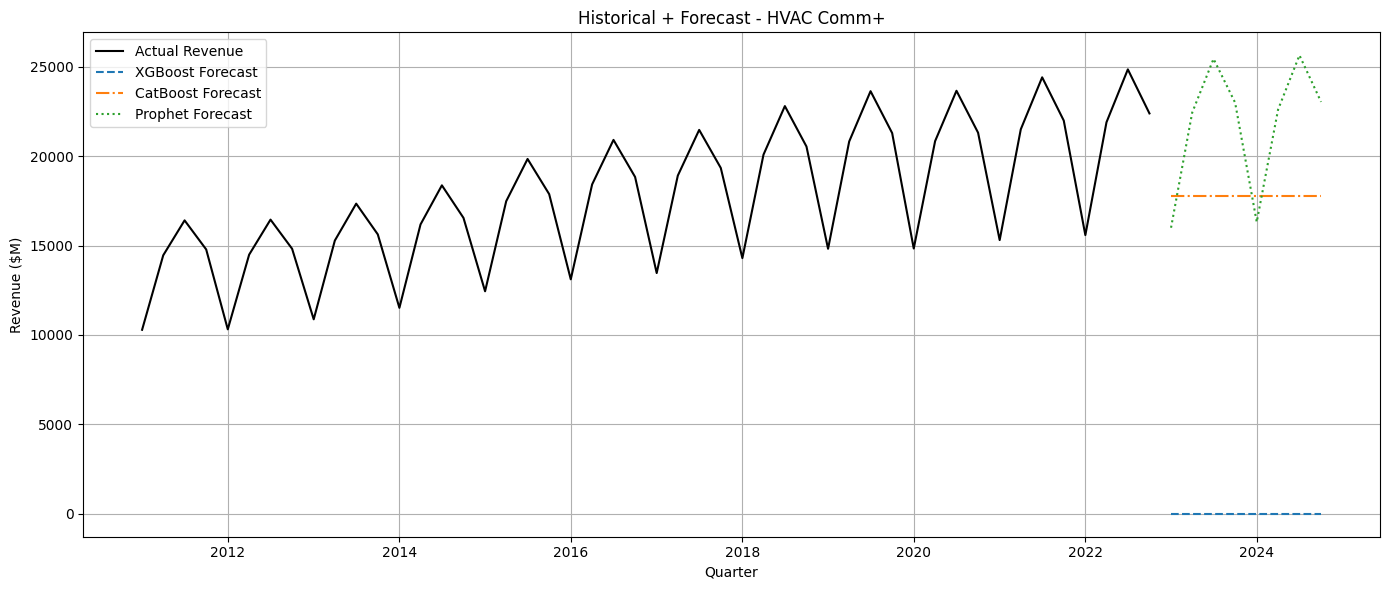

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/deja12jb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/_1f9sand.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5212', 'data', 'file=/tmp/tmpkatl30rk/deja12jb.json', 'init=/tmp/tmpkatl30rk/_1f9sand.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modelms2l8n19/prophet_model-20250509181503.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:15:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Processing: Plumbing Resi S&R
Features used for Plumbing Resi S&R: ['year', 'qtr', 'qtrly_estabs_count', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'taxable_qtrly_wages', 'qtrly_contributions', 'avg_wkly_wage', 'lq_qtrly_estabs_count', 'lq_month1_emplvl', 'lq_month2_emplvl', 'lq_month3_emplvl', 'lq_total_qtrly_wages', 'lq_taxable_qtrly_wages', 'lq_qtrly_contributions', 'lq_avg_wkly_wage', 'oty_qtrly_estabs_count_chg', 'oty_qtrly_estabs_count_pct_chg', 'oty_month1_emplvl_chg', 'oty_month1_emplvl_pct', 'oty_month2_emplvl_chg', 'oty_month2_emplvl_pct', 'oty_month3_emplvl_chg', 'oty_month3_emplvl_pct', 'oty_total_qtrly_wages_chg', 'oty_total_qtrly_wages_pct', 'oty_taxable_qtrly_wages_chg', 'oty_taxable_qtrly_wages_chg.1', 'oty_qtrly_contributions_chg', 'oty_qtrly_contributions_pct', 'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct', 'oty_month1_emplvl_pct_chg', 'oty_month2_emplvl_pct_chg', 'oty_month3_emplvl_pct_chg', 'oty_total_qtrly_wages_pct_chg', 'oty_taxab

18:15:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 80/80 [02:31<00:00,  1.89s/trial, best loss: 310.3888873430655]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/zliq2zzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/85mhzqjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52635', 'data', 'file=/tmp/tmpkatl30rk/zliq2zzw.json', 'init=/tmp/tmpkatl30rk/85mhzqjr.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modeljokgxl6w/prophet_model-20250509181816.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Backtest metrics for Plumbing Resi S&R:
  XGBoost -> MAE: 509.38, MAPE: 961.77%, RMSE: 585.39
  CatBoost -> MAE: 544.63, MAPE: 1027.95%, RMSE: 626.65
  Prophet -> MAE: 142.34, MAPE: 276.38%, RMSE: 146.36


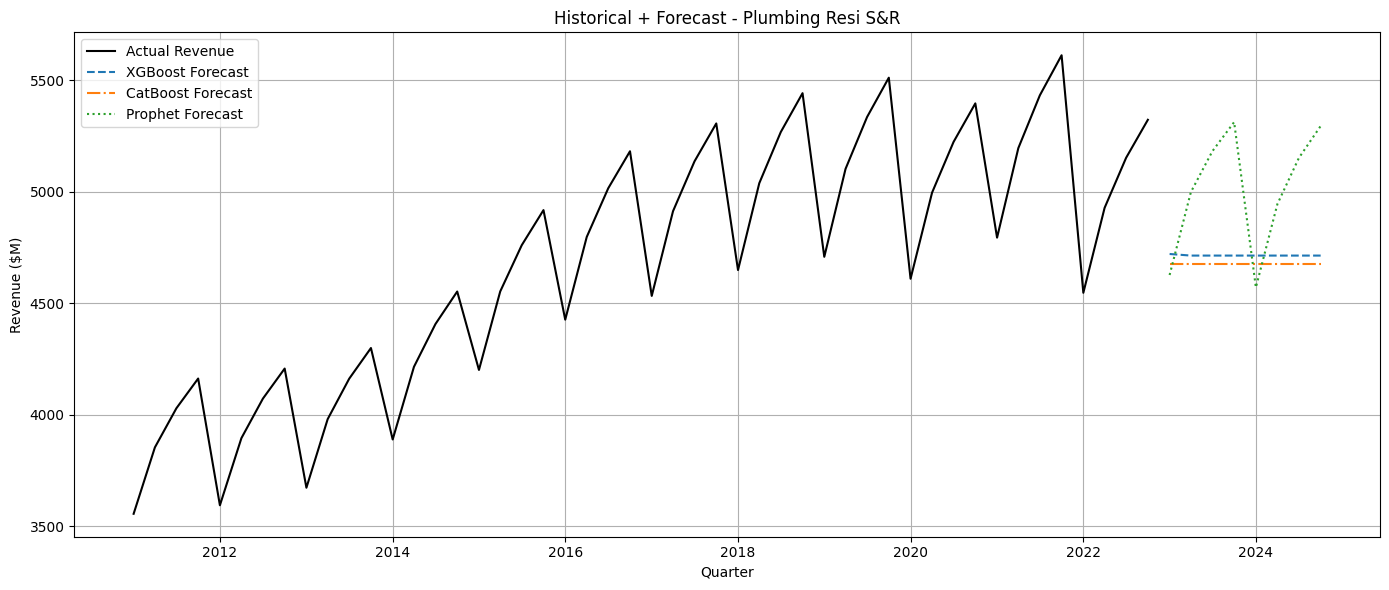

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/w1n00umt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/nbn5v_d4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21634', 'data', 'file=/tmp/tmpkatl30rk/w1n00umt.json', 'init=/tmp/tmpkatl30rk/nbn5v_d4.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_modelczxlwab9/prophet_model-20250509181817.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Processing: Plumbing Comm+
Features used for Plumbing Comm+: ['year', 'qtr', 'qtrly_estabs_count', 'month1_emplvl', 'month2_emplvl', 'month3_emplvl', 'total_qtrly_wages', 'taxable_qtrly_wages', 'qtrly_contributions', 'avg_wkly_wage', 'lq_qtrly_estabs_count', 'lq_month1_emplvl', 'lq_month2_emplvl', 'lq_month3_emplvl', 'lq_total_qtrly_wages', 'lq_taxable_qtrly_wages', 'lq_qtrly_contributions', 'lq_avg_wkly_wage', 'oty_qtrly_estabs_count_chg', 'oty_qtrly_estabs_count_pct_chg', 'oty_month1_emplvl_chg', 'oty_month1_emplvl_pct', 'oty_month2_emplvl_chg', 'oty_month2_emplvl_pct', 'oty_month3_emplvl_chg', 'oty_month3_emplvl_pct', 'oty_total_qtrly_wages_chg', 'oty_total_qtrly_wages_pct', 'oty_taxable_qtrly_wages_chg', 'oty_taxable_qtrly_wages_chg.1', 'oty_qtrly_contributions_chg', 'oty_qtrly_contributions_pct', 'oty_avg_wkly_wage_chg', 'oty_avg_wkly_wage_pct', 'oty_month1_emplvl_pct_chg', 'oty_month2_emplvl_pct_chg', 'oty_month3_emplvl_pct_chg', 'oty_total_qtrly_wages_pct_chg', 'oty_taxable_qtr

18:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 80/80 [02:39<00:00,  2.00s/trial, best loss: 1548.0406269694774]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/cowf59wr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkatl30rk/zayg3o1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81434', 'data', 'file=/tmp/tmpkatl30rk/cowf59wr.json', 'init=/tmp/tmpkatl30rk/zayg3o1w.json', 'output', 'file=/tmp/tmpkatl30rk/prophet_model9la7_2ti/prophet_model-20250509182138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Backtest metrics for Plumbing Comm+:
  XGBoost -> MAE: 2370.66, MAPE: 939.36%, RMSE: 2825.04
  CatBoost -> MAE: 2915.84, MAPE: 1155.62%, RMSE: 3451.11
  Prophet -> MAE: 679.38, MAPE: 281.64%, RMSE: 697.53


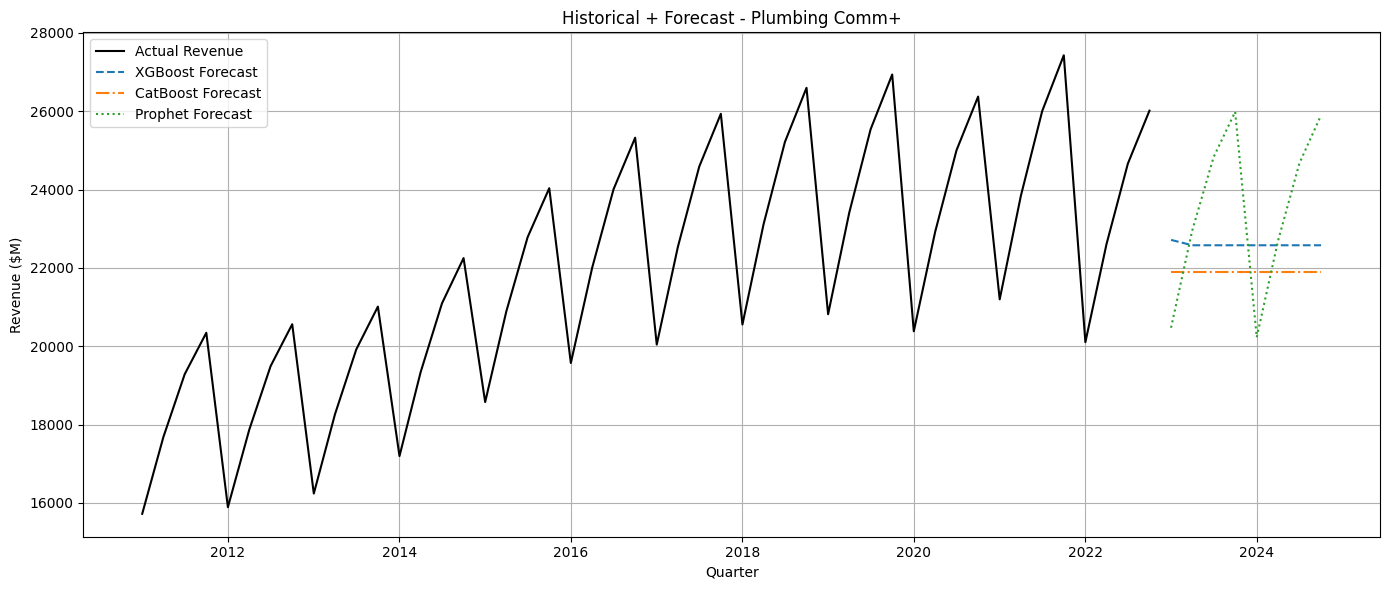

In [13]:
forecast_horizon = 8
max_evals = 80
skip_prophet = False

xgb_space = {
    'n_estimators': hp.choice('n_estimators', range(50, 300, 50)),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.001), np.log(1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(1)),
}

catboost_space = {
    'iterations': hp.choice('iterations', range(100, 700, 100)),
    'depth': hp.choice('depth', range(4, 10)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
}

def objective_xgb(params):

    """
    Objective function for XGBoost model optimization using time series cross-validation.

    Parameters
    ----------
    params : dict
        Dictionary of hyperparameters to be passed to the XGBoost regressor.

    Returns
    -------
    dict
        A dictionary containing:
        - 'loss': mean RMSE across validation folds.
        - 'status': optimization status code (STATUS_OK).
    """

    model = xgb.XGBRegressor(objective='reg:squarederror', **params)
    tscv = TimeSeriesSplit(n_splits=3)
    rmses = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    return {'loss': np.mean(rmses), 'status': STATUS_OK}

def objective_catboost(params):

    """
    Objective function for CatBoost model optimization using time series cross-validation.

    Parameters
    ----------
    params : dict
        Dictionary of hyperparameters to be passed to the CatBoost regressor.

    Returns
    -------
    dict
        A dictionary containing:
        - 'loss': mean RMSE across validation folds.
        - 'status': optimization status code (STATUS_OK).
    """

    model = CatBoostRegressor(verbose=0, **params)
    tscv = TimeSeriesSplit(n_splits=3)
    rmses = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    return {'loss': np.mean(rmses), 'status': STATUS_OK}

results = {}

for category in quarterly_df['Trade+BF'].unique():
    print(f"\nProcessing: {category}")

    sub_df = quarterly_df[quarterly_df['Trade+BF'] == category].copy()
    sub_df['revenue_lag1'] = sub_df['Revenue'].shift(1)
    sub_df['revenue_lag2'] = sub_df['Revenue'].shift(2)
    sub_df['revenue_lag3'] = sub_df['Revenue'].shift(3)
    sub_df['revenue_lag4'] = sub_df['Revenue'].shift(4)
    sub_df['rolling_mean_4'] = sub_df['Revenue'].rolling(4).mean()
    sub_df['quarter'] = sub_df.index.quarter
    sub_df['year'] = sub_df.index.year

    for i in range(1, 5):
        sub_df[f'quarter_sin_{i}'] = np.sin(2 * np.pi * sub_df.index.quarter / i)
        sub_df[f'quarter_cos_{i}'] = np.cos(2 * np.pi * sub_df.index.quarter / i)

    sub_df.dropna(inplace=True)

    excluded_cols = ['trade+bf', 'industry_code', 'business focus', 'trade', 'industry_title', 'size_code']
    candidate_features = [col for col in sub_df.columns if col.lower() not in excluded_cols]

    for feature in candidate_features:
        if sub_df[feature].dtype == 'object':
            le = LabelEncoder()
            sub_df[feature] = le.fit_transform(sub_df[feature])

    print(f"Features used for {category}: {candidate_features}")

    X = sub_df[candidate_features]
    y = sub_df['Revenue']

    if not skip_prophet:
        prophet_df = sub_df.reset_index().rename(columns={'yearqtr': 'ds', 'Revenue': 'y'})[['ds', 'y']]
        model_prophet = Prophet(seasonality_mode='multiplicative')
        model_prophet.fit(prophet_df)
        future_prophet = model_prophet.make_future_dataframe(periods=forecast_horizon, freq='QS')
        forecast_prophet = model_prophet.predict(future_prophet)
        future_preds_prophet = forecast_prophet['yhat'][-forecast_horizon:].values
    else:
        future_preds_prophet = [np.nan] * forecast_horizon

    trials_xgb = Trials()
    best_params_xgb = fmin(fn=objective_xgb, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials_xgb)
    final_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params_xgb)
    final_model_xgb.fit(X, y)

    trials_catboost = Trials()
    best_params_catboost = fmin(fn=objective_catboost, space=catboost_space, algo=tpe.suggest, max_evals=max_evals, trials=trials_catboost)
    final_model_catboost = CatBoostRegressor(verbose=0, **best_params_catboost)
    final_model_catboost.fit(X, y)

    future_preds_xgb = []
    future_preds_catboost = []
    last_row_xgb = last_row_catboost = X.iloc[-1].copy()

    for _ in range(forecast_horizon):
        for last_row in [last_row_xgb, last_row_catboost]:
            last_row['quarter'] = (last_row['quarter'] % 4) + 1
            last_row['year'] += (last_row['quarter'] == 1)
            for j in range(1, 5):
                last_row[f'quarter_sin_{j}'] = np.sin(2 * np.pi * last_row['quarter'] / j)
                last_row[f'quarter_cos_{j}'] = np.cos(2 * np.pi * last_row['quarter'] / j)

        input_xgb = pd.DataFrame([last_row_xgb])
        input_catboost = pd.DataFrame([last_row_catboost])
        future_preds_xgb.append(final_model_xgb.predict(input_xgb)[0])
        future_preds_catboost.append(final_model_catboost.predict(input_catboost)[0])
        last_row_xgb['revenue_lag1'] = future_preds_xgb[-1]
        last_row_catboost['revenue_lag1'] = future_preds_catboost[-1]

    results[category] = {
        'xgb': future_preds_xgb,
        'catboost': future_preds_catboost,
        'prophet': future_preds_prophet
    }
    if len(y) > forecast_horizon:
        y_train_backtest = y.iloc[:-forecast_horizon]
        y_test_backtest = y.iloc[-forecast_horizon:]
        X_train_backtest = X.iloc[:-forecast_horizon]
        X_test_backtest = X.iloc[-forecast_horizon:]

        # Re-train models on truncated training data
        backtest_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params_xgb)
        backtest_xgb.fit(X_train_backtest, y_train_backtest)
        preds_xgb_backtest = backtest_xgb.predict(X_test_backtest)

        backtest_catboost = CatBoostRegressor(verbose=0, **best_params_catboost)
        backtest_catboost.fit(X_train_backtest, y_train_backtest)
        preds_catboost_backtest = backtest_catboost.predict(X_test_backtest)

        if not skip_prophet:
            prophet_backtest_df = sub_df.iloc[:-forecast_horizon].reset_index().rename(columns={'yearqtr': 'ds', 'Revenue': 'y'})[['ds', 'y']]
            model_prophet_backtest = Prophet(seasonality_mode='multiplicative')
            model_prophet_backtest.fit(prophet_backtest_df)
            future_backtest = model_prophet_backtest.make_future_dataframe(periods=forecast_horizon, freq='QS')
            forecast_backtest = model_prophet_backtest.predict(future_backtest)
            preds_prophet_backtest = forecast_backtest['yhat'][-forecast_horizon:].values
        else:
            preds_prophet_backtest = [np.nan] * forecast_horizon

        # XGBoost metrics
        mae_xgb = mean_absolute_error(y_test_backtest, preds_xgb_backtest)
        mape_xgb = mean_absolute_percentage_error(y_test_backtest, preds_xgb_backtest)
        rmse_xgb = np.sqrt(mean_squared_error(y_test_backtest, preds_xgb_backtest))

        # CatBoost metrics
        mae_catboost = mean_absolute_error(y_test_backtest, preds_catboost_backtest)
        mape_catboost = mean_absolute_percentage_error(y_test_backtest, preds_catboost_backtest)
        rmse_catboost = np.sqrt(mean_squared_error(y_test_backtest, preds_catboost_backtest))

        # Prophet metrics
        if not skip_prophet:
            mae_prophet = mean_absolute_error(y_test_backtest, preds_prophet_backtest)
            mape_prophet = mean_absolute_percentage_error(y_test_backtest, preds_prophet_backtest)
            rmse_prophet = np.sqrt(mean_squared_error(y_test_backtest, preds_prophet_backtest))
        else:
            mae_prophet = mape_prophet = rmse_prophet = np.nan

        results[category].update({
            'mae_xgb': mae_xgb,
            'mape_xgb': mape_xgb,
            'rmse_xgb': rmse_xgb,
            'mae_catboost': mae_catboost,
            'mape_catboost': mape_catboost,
            'rmse_catboost': rmse_catboost,
            'mae_prophet': mae_prophet,
            'mape_prophet': mape_prophet,
            'rmse_prophet': rmse_prophet
        })

        print(f"Backtest metrics for {category}:")
        print(f"  XGBoost -> MAE: {mae_xgb:.2f}, MAPE: {mape_xgb:.2%}, RMSE: {rmse_xgb:.2f}")
        print(f"  CatBoost -> MAE: {mae_catboost:.2f}, MAPE: {mape_catboost:.2%}, RMSE: {rmse_catboost:.2f}")
        if not skip_prophet:
            print(f"  Prophet -> MAE: {mae_prophet:.2f}, MAPE: {mape_prophet:.2%}, RMSE: {rmse_prophet:.2f}")
                # Create full timeline for plotting
        full_index = sub_df.index
        future_index = pd.date_range(start=full_index[-1] + pd.DateOffset(months=3), periods=forecast_horizon, freq='QS')

        # Combine historical and forecast series
        actual_series = pd.Series(y.values, index=full_index, name="Actual Revenue")
        forecast_xgb_series = pd.Series(future_preds_xgb, index=future_index, name="XGBoost Forecast")
        forecast_catboost_series = pd.Series(future_preds_catboost, index=future_index, name="CatBoost Forecast")
        forecast_prophet_series = pd.Series(future_preds_prophet, index=future_index, name="Prophet Forecast") if not skip_prophet else None

        # Plot
        plt.figure(figsize=(14, 6))
        plt.plot(actual_series.index, actual_series.values, label="Actual Revenue", color='black')
        plt.plot(forecast_xgb_series.index, forecast_xgb_series.values, label="XGBoost Forecast", linestyle='--')
        plt.plot(forecast_catboost_series.index, forecast_catboost_series.values, label="CatBoost Forecast", linestyle='-.')
        if not skip_prophet:
            plt.plot(forecast_prophet_series.index, forecast_prophet_series.values, label="Prophet Forecast", linestyle=':')

        plt.title(f"Historical + Forecast - {category}")
        plt.xlabel("Quarter")
        plt.ylabel("Revenue ($M)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


## Error comparison

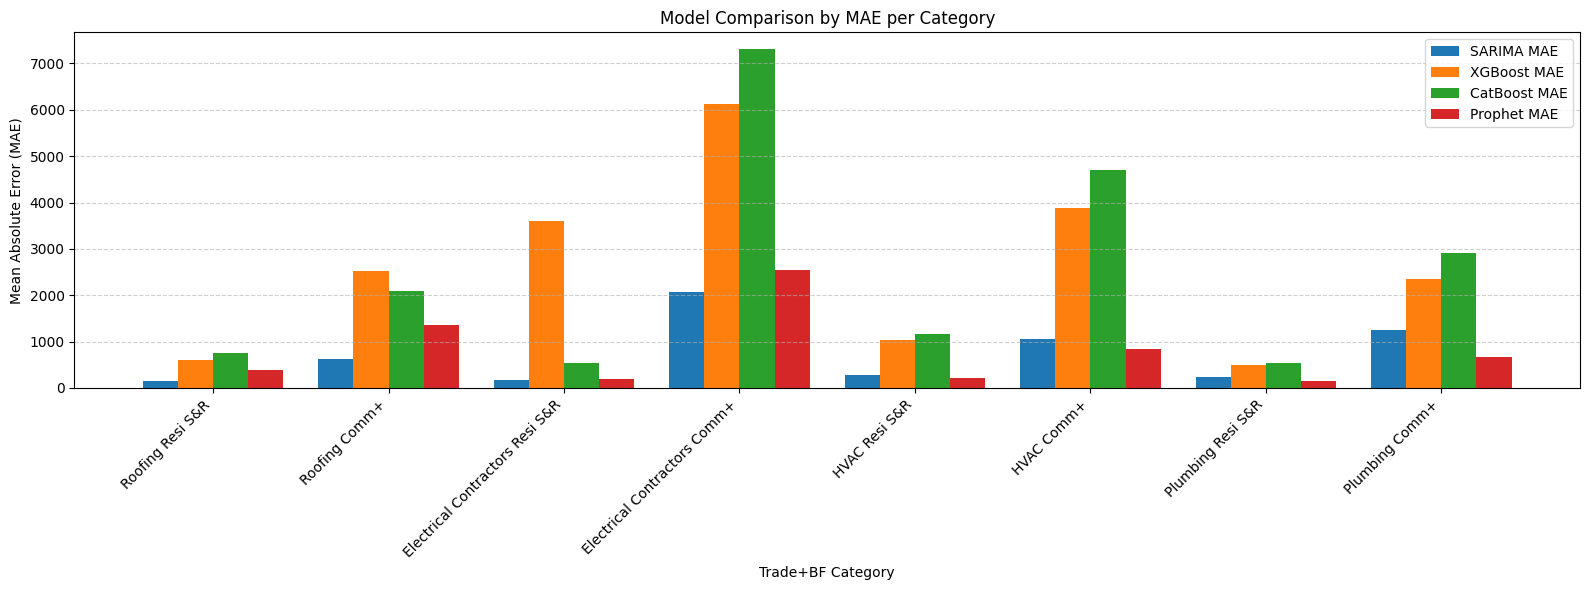

In [ ]:
# Extract categories
categories = list(results.keys())

# Extract MAEs for all 4 models
mae_xgb = [results[cat].get('mae_xgb', np.nan) for cat in categories]
mae_catboost = [results[cat].get('mae_catboost', np.nan) for cat in categories]
mae_prophet = [results[cat].get('mae_prophet', np.nan) for cat in categories]
mae_sarima = [mae_dict.get(cat, np.nan) for cat in categories]

# Set bar positions
bar_width = 0.2
x = np.arange(len(categories))

# Plotting
plt.figure(figsize=(16, 6))
plt.bar(x - 1.5*bar_width, mae_sarima, width=bar_width, label='SARIMA MAE')
plt.bar(x - 0.5*bar_width, mae_xgb, width=bar_width, label='XGBoost MAE')
plt.bar(x + 0.5*bar_width, mae_catboost, width=bar_width, label='CatBoost MAE')
plt.bar(x + 1.5*bar_width, mae_prophet, width=bar_width, label='Prophet MAE')

# Formatting
plt.xticks(x, categories, rotation=45, ha='right')
plt.xlabel("Trade+BF Category")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Comparison by MAE per Category")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


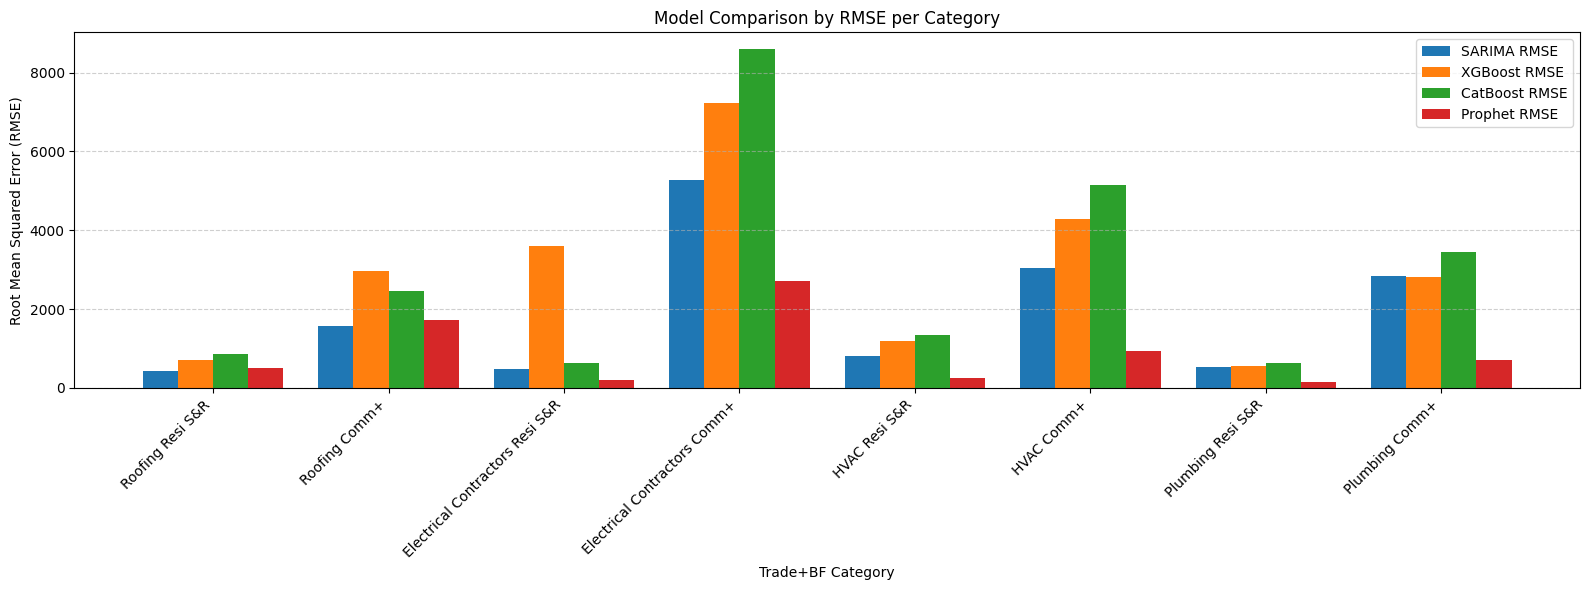

In [ ]:
# Extract RMSE for all 4 models
rmse_xgb = [results[cat].get('rmse_xgb', np.nan) for cat in categories]
rmse_catboost = [results[cat].get('rmse_catboost', np.nan) for cat in categories]
rmse_prophet = [results[cat].get('rmse_prophet', np.nan) for cat in categories]
rmse_sarima = [rmse_dict.get(cat, np.nan) for cat in categories]  # Make sure rmse_dict exists

# Plotting
plt.figure(figsize=(16, 6))
plt.bar(x - 1.5*bar_width, rmse_sarima, width=bar_width, label='SARIMA RMSE')
plt.bar(x - 0.5*bar_width, rmse_xgb, width=bar_width, label='XGBoost RMSE')
plt.bar(x + 0.5*bar_width, rmse_catboost, width=bar_width, label='CatBoost RMSE')
plt.bar(x + 1.5*bar_width, rmse_prophet, width=bar_width, label='Prophet RMSE')

plt.xticks(x, categories, rotation=45, ha='right')
plt.xlabel("Trade+BF Category")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model Comparison by RMSE per Category")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


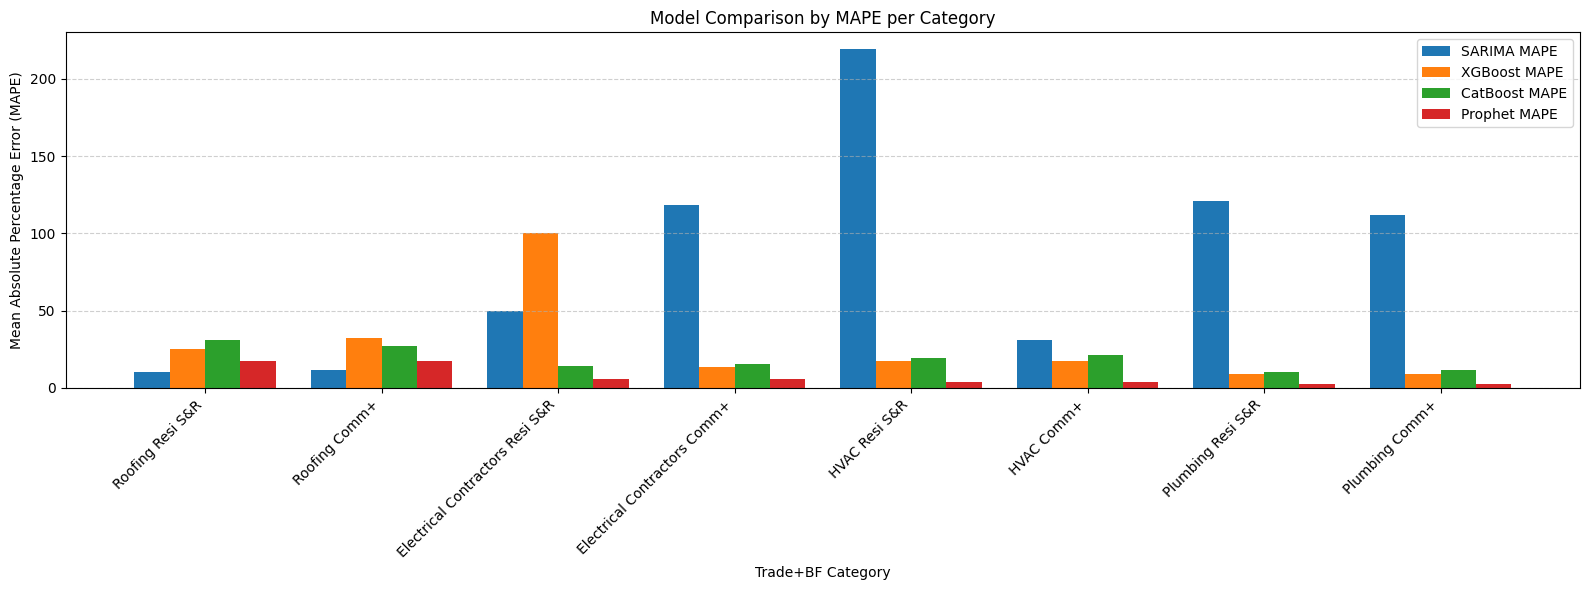

In [ ]:
# Extract MAPE for all 4 models
mape_xgb = [results[cat].get('mape_xgb', np.nan) for cat in categories]
mape_catboost = [results[cat].get('mape_catboost', np.nan) for cat in categories]
mape_prophet = [results[cat].get('mape_prophet', np.nan) for cat in categories]
mape_sarima = [mape_dict.get(cat, np.nan) for cat in categories]  # Make sure mape_dict exists

# Plotting
plt.figure(figsize=(16, 6))
plt.bar(x - 1.5*bar_width, mape_sarima, width=bar_width, label='SARIMA MAPE')
plt.bar(x - 0.5*bar_width, mape_xgb, width=bar_width, label='XGBoost MAPE')
plt.bar(x + 0.5*bar_width, mape_catboost, width=bar_width, label='CatBoost MAPE')
plt.bar(x + 1.5*bar_width, mape_prophet, width=bar_width, label='Prophet MAPE')

plt.xticks(x, categories, rotation=45, ha='right')
plt.xlabel("Trade+BF Category")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.title("Model Comparison by MAPE per Category")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Based on these 3 error graphs, in the majority of the cases Prophet performs the best, second please goes to SARIMA. But we would need to look further into this by examining this through suming up the errors for each model to see which one has the lowest value accross all categories.

In [ ]:
# List of models to compare
models = ['xgb', 'catboost', 'prophet', 'sarima']

# Initialize dictionary to store best model per category
best_models = {}

# Loop through each category
for cat in categories:
    # Dictionary to hold metrics per model
    model_scores = {}

    for model in models:
        # Get errors from results and fallback dicts
        mae = results[cat].get(f'mae_{model}', mae_dict.get(cat, np.nan) if model == 'sarima' else np.nan)
        rmse = results[cat].get(f'rmse_{model}', rmse_dict.get(cat, np.nan) if model == 'sarima' else np.nan)
        mape = results[cat].get(f'mape_{model}', mape_dict.get(cat, np.nan) if model == 'sarima' else np.nan)

        # Check if all metrics exist for this model
        if not np.isnan(mae) and not np.isnan(rmse) and not np.isnan(mape):
            # Aggregate score (you can weight metrics differently if desired)
            total_score = mae + rmse + mape
            model_scores[model] = total_score

    # Select model with lowest total score
    if model_scores:
        best_model = min(model_scores, key=model_scores.get)
        best_models[cat] = best_model
    else:
        best_models[cat] = 'Insufficient Data'

# Display results
for cat, model in best_models.items():
    print(f"Best model for {cat}: {model}")


Best model for Roofing Resi S&R: sarima
Best model for Roofing Comm+: sarima
Best model for Electrical Contractors Resi S&R: prophet
Best model for Electrical Contractors Comm+: prophet
Best model for HVAC Resi S&R: prophet
Best model for HVAC Comm+: prophet
Best model for Plumbing Resi S&R: prophet
Best model for Plumbing Comm+: prophet


## Creating Dataframe for the best model.

In [ ]:
# Create a list to hold forecast rows
forecast_rows = []

for category, model_results in results.items():
    # Forecast horizon must match what you used earlier
    forecast_dates = pd.date_range(
        start=quarterly_df[quarterly_df['Trade+BF'] == category].index.max() + pd.DateOffset(months=3),
        periods=forecast_horizon,
        freq='QS'
    )
    prophet_preds = model_results.get('prophet', [np.nan] * forecast_horizon)

    for i in range(forecast_horizon):
        forecast_rows.append({
            'Date': forecast_dates[i],
            'Trade+BF': category,
            'Prophet Forecast': prophet_preds[i],
        })

# Create final forecast dataframe
forecast_df = pd.DataFrame(forecast_rows)

# Display or debug
print(forecast_df.head())

        Date          Trade+BF  Prophet Forecast
0 2023-01-01  Roofing Resi S&R       1293.645689
1 2023-04-01  Roofing Resi S&R       1937.385130
2 2023-07-01  Roofing Resi S&R       2599.141700
3 2023-10-01  Roofing Resi S&R       2887.092248
4 2024-01-01  Roofing Resi S&R       1197.785188


## BigQuery connection setup

Uploading two in-memory DataFrames — quarterly_df and forecast_df — to Google BigQuery, replacing data in the corresponding staging tables. It handles authentication, schema enforcement, and data formatting to ensure clean and structured ingestion.

In [ ]:
uploaded = files.upload()

Saving servicetitan-436706-38069a01410a.json to servicetitan-436706-38069a01410a.json


In [ ]:
# Replace with your key filename
key_path = "servicetitan-436706-38069a01410a.json"

# Authenticate
credentials = service_account.Credentials.from_service_account_file(key_path)

# Create BigQuery client
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

print(f"Authenticated to project: {credentials.project_id}")

Authenticated to project: servicetitan-436706


In [ ]:
quarterly_df = quarterly_df.rename(columns={"GDP(Trillions $)": "GDP_Trillions_dollars"})

from google.cloud import bigquery
import pandas as pd
import numpy as np

# --- Setup ---
project_id = "servicetitan-436706"
dataset_id = "capstone_dataset"
dataset_ref = f"{project_id}.{dataset_id}"

key_path = "servicetitan-436706-38069a01410a.json"
client = bigquery.Client.from_service_account_json(key_path)

# --- Table schemas ---
table_schemas = {
    "staging_quarterly_data": [
        bigquery.SchemaField("yearqtr", "DATE"),
        bigquery.SchemaField("Trade", "STRING"),
        bigquery.SchemaField("Business Focus", "STRING"),
        bigquery.SchemaField("Trade+BF", "STRING"),
        bigquery.SchemaField("industry_code", "STRING"),
        bigquery.SchemaField("year", "INT64"),
        bigquery.SchemaField("qtr", "INT64"),
        bigquery.SchemaField("qtrly_estabs_count", "FLOAT64"),
        bigquery.SchemaField("month1_emplvl", "FLOAT64"),
        bigquery.SchemaField("month2_emplvl", "FLOAT64"),
        bigquery.SchemaField("month3_emplvl", "FLOAT64"),
        bigquery.SchemaField("total_qtrly_wages", "FLOAT64"),
        bigquery.SchemaField("taxable_qtrly_wages", "FLOAT64"),
        bigquery.SchemaField("qtrly_contributions", "FLOAT64"),
        bigquery.SchemaField("avg_wkly_wage", "FLOAT64"),
        bigquery.SchemaField("lq_qtrly_estabs_count", "FLOAT64"),
        bigquery.SchemaField("lq_month1_emplvl", "FLOAT64"),
        bigquery.SchemaField("lq_month2_emplvl", "FLOAT64"),
        bigquery.SchemaField("lq_month3_emplvl", "FLOAT64"),
        bigquery.SchemaField("lq_total_qtrly_wages", "FLOAT64"),
        bigquery.SchemaField("lq_taxable_qtrly_wages", "FLOAT64"),
        bigquery.SchemaField("lq_qtrly_contributions", "FLOAT64"),
        bigquery.SchemaField("lq_avg_wkly_wage", "FLOAT64"),
        bigquery.SchemaField("oty_month1_emplvl_chg", "FLOAT64"),
        bigquery.SchemaField("oty_month1_emplvl_pct", "FLOAT64"),
        bigquery.SchemaField("oty_month2_emplvl_chg", "FLOAT64"),
        bigquery.SchemaField("oty_month2_emplvl_pct", "FLOAT64"),
        bigquery.SchemaField("oty_month3_emplvl_chg", "FLOAT64"),
        bigquery.SchemaField("oty_month3_emplvl_pct", "FLOAT64"),
        bigquery.SchemaField("oty_avg_wkly_wage_chg", "FLOAT64"),
        bigquery.SchemaField("oty_avg_wkly_wage_pct", "FLOAT64"),
        bigquery.SchemaField("GDP_Trillions_dollars", "FLOAT64"),
        bigquery.SchemaField("Housing Starts", "FLOAT64"),
        bigquery.SchemaField("Revenue", "FLOAT64")
    ],
    "staging_forecast_df": [
        bigquery.SchemaField("Date", "DATE"),
        bigquery.SchemaField("Trade+BF", "STRING"),
        bigquery.SchemaField("Prophet Forecast", "FLOAT64"),
    ]
}

table_dataframes = {
    "staging_quarterly_data": quarterly_df.copy(),
    "staging_forecast_df": forecast_df.copy()
}

# --- Normalize and upload data ---
for table_name, df in table_dataframes.items():
    print(f"\n📤 Uploading DataFrame to {table_name}...")

    # Convert date columns
    for col in df.columns:
        if "date" in col.lower() or "yearqtr" in col.lower():
            df[col] = pd.to_datetime(df[col], errors='coerce').dt.date

    # Force industry_code to string if exists
    if "industry_code" in df.columns:
        df['industry_code'] = df['industry_code'].astype(str)

    # Fix column names with dots
    df.columns = [col.replace(".", "_") for col in df.columns]

    # Define table reference
    table_ref = f"{dataset_ref}.{table_name}"

    # Create table if it doesn't exist
    table = bigquery.Table(table_ref, schema=table_schemas[table_name])
    try:
        client.create_table(table)
        print(f"✅ Created table: {table_name}")
    except Exception as e:
        if "Already Exists" in str(e):
            print(f"⚠️ Table already exists: {table_name}, replacing data...")
        else:
            raise

    # Upload
    job_config = bigquery.LoadJobConfig(
        schema=table_schemas[table_name],
        write_disposition="WRITE_TRUNCATE"
    )
    load_job = client.load_table_from_dataframe(df, table_ref, job_config=job_config)
    load_job.result()
    print(f"✅ Uploaded {len(df)} rows to {table_name}")

print("\n🎉 All in-memory DataFrames uploaded to BigQuery.")



📤 Uploading DataFrame to staging_quarterly_data...
⚠️ Table already exists: staging_quarterly_data, replacing data...
✅ Uploaded 416 rows to staging_quarterly_data

📤 Uploading DataFrame to staging_forecast_df...
⚠️ Table already exists: staging_forecast_df, replacing data...
✅ Uploaded 64 rows to staging_forecast_df

🎉 All in-memory DataFrames uploaded to BigQuery.
